## EIA Monthly Electric Grid Data - CO2 Emissions Intensity Model

Goal:  predict how adding X megawatts of solar or wind generation capacity within a Balancing Authority (BA) will affect CO2 emissions per megawatt-hour generated

Monthly generation capacity and operations data was retrieved from the U.S. Energy Information Administration API

See gencap_EDA_prep and genops_EDA_prep for data cleaning and transformation

In [516]:
import pandas as pd
import numpy as np

# load balancing authority generation configuration and operation (output) files to data frames
explan_path = 'genconf.csv'
resp_path = 'genout.csv'
genconf = pd.read_csv(explan_path, low_memory=False)
genout = pd.read_csv(resp_path, low_memory=False)

"genconf" holds monthly generation configuration data for each BA. Columns named with EIA energy source codes contain total installed generation capacity for that energy source. "av_lat" and "av_lon" contain the mean location of power plants in the BA.

In [517]:
genconf.head()

,ba_code,period,BIT,DFO,GEO,JF,KER,LIG,MSW,NG,...,SGP,SUB,SUN,TDF,WAT,WC,WND,WO,av_lat,av_lon
0,AEC,2013-01-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
1,AEC,2013-02-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
2,AEC,2013-03-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
3,AEC,2013-04-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644
4,AEC,2013-05-01,538.0,0.0,0.0,0.0,0.0,0.0,0.0,1330.0,...,0.0,0.0,0.0,0.0,8.2,0.0,0.0,0.0,31.264018,-86.673644


In [518]:
# EIA data is not finalized until fall of the year following the reporting period, so cut off data at end of 2021
data_cutoff = '2022-01-01'
genconf = genconf[genconf.period < data_cutoff]

Normalize installed capacity for each energy source as a proportion of total capacity

In [519]:
# calculate total generation capacity per row
genconf['total_cap_mw'] = genconf.drop(['av_lat','av_lon'], axis=1).sum(axis=1, numeric_only=True)

In [520]:
genconf.head().T

,0,1,2,3,4
ba_code,AEC,AEC,AEC,AEC,AEC
period,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01
BIT,538.0,538.0,538.0,538.0,538.0
DFO,0.0,0.0,0.0,0.0,0.0
GEO,0.0,0.0,0.0,0.0,0.0
JF,0.0,0.0,0.0,0.0,0.0
KER,0.0,0.0,0.0,0.0,0.0
LIG,0.0,0.0,0.0,0.0,0.0
MSW,0.0,0.0,0.0,0.0,0.0
NG,1330.0,1330.0,1330.0,1330.0,1330.0


In [521]:
# divide capacity per energy source by total capacity
#genconf['total_cap_mw_temp'] = genconf['total_cap_mw']
genconf_norm = genconf[['ba_code','period','av_lat','av_lon','total_cap_mw']].join(genconf.drop(['av_lat','av_lon'], axis=1).select_dtypes \
                                                               (include=np.number).apply(lambda x : x/genconf['total_cap_mw']) \
                                                                .drop(columns=['total_cap_mw']))
genconf_norm.head()

,ba_code,period,av_lat,av_lon,total_cap_mw,BIT,DFO,GEO,JF,KER,...,RFO,SGC,SGP,SUB,SUN,TDF,WAT,WC,WND,WO
0,AEC,2013-01-01,31.264018,-86.673644,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
1,AEC,2013-02-01,31.264018,-86.673644,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
2,AEC,2013-03-01,31.264018,-86.673644,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
3,AEC,2013-04-01,31.264018,-86.673644,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
4,AEC,2013-05-01,31.264018,-86.673644,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0


Normalize average latitude and longitude features

In [522]:
#normalize latitude to range 0,1
genconf_norm['av_lat'] = genconf_norm['av_lat'].apply(lambda x: (x-genconf_norm['av_lat'].min())/(genconf_norm['av_lat'].max() \
                                                                       - genconf_norm['av_lat'].min()))

In [523]:
#normalize longitude to range 0,1
genconf_norm['av_lon'] = genconf_norm['av_lon'].apply(lambda x: (x-genconf_norm['av_lon'].min())/(genconf_norm['av_lon'].max() \
                                                                       - genconf_norm['av_lon'].min()))

In [524]:
genconf_norm.head()

,ba_code,period,av_lat,av_lon,total_cap_mw,BIT,DFO,GEO,JF,KER,...,RFO,SGC,SGP,SUB,SUN,TDF,WAT,WC,WND,WO
0,AEC,2013-01-01,0.247954,0.704774,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
1,AEC,2013-02-01,0.247954,0.704774,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
2,AEC,2013-03-01,0.247954,0.704774,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
3,AEC,2013-04-01,0.247954,0.704774,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0
4,AEC,2013-05-01,0.247954,0.704774,1881.0,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004359,0.0,0.0,0.0


"genout" contains monthly data for each BA:  net electricity generated (megawatt-hours), CO2 emitted (metric kilotons), and Carbon Intensity aka specific CO2 emission (kilograms per megawatt-hour)

In [525]:
genout.head()

,Unnamed: 0,period,ba_code,gen_mwh,co2_kton,kg_co2_per_mwh
0,0,2008-01-01,AEC,956757.90,798.625086,834.720138
1,1,2008-01-01,AECI,3538481.16,2810.807112,794.354127
2,2,2008-01-01,AVA,1171593.70,139.373992,118.961029
3,3,2008-01-01,AZPS,4535011.56,4078.848443,899.413020
4,4,2008-01-01,BANC,1456123.84,557.080674,382.577813


In [526]:
genout = genout[['ba_code', 'period', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh']]

In [527]:
genout.head()

,ba_code,period,gen_mwh,co2_kton,kg_co2_per_mwh
0,AEC,2008-01-01,956757.90,798.625086,834.720138
1,AECI,2008-01-01,3538481.16,2810.807112,794.354127
2,AVA,2008-01-01,1171593.70,139.373992,118.961029
3,AZPS,2008-01-01,4535011.56,4078.848443,899.413020
4,BANC,2008-01-01,1456123.84,557.080674,382.577813


Normalize electricity generated as a proportion of total capacity. Intent is to use this as a feature representing how much of its capacity a BA used on average.

In [528]:
# join total generation capacity to genout
genout_norm = genout.set_index(['ba_code','period']).join(genconf[['ba_code','period','total_cap_mw']].set_index(['ba_code','period']))
genout_norm.head()

,,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw
ba_code,period,,,,
AEC,2008-01-01,956757.90,798.625086,834.720138,NaN
AECI,2008-01-01,3538481.16,2810.807112,794.354127,NaN
AVA,2008-01-01,1171593.70,139.373992,118.961029,NaN
AZPS,2008-01-01,4535011.56,4078.848443,899.413020,NaN
BANC,2008-01-01,1456123.84,557.080674,382.577813,NaN


In [529]:
genout_norm.shape

(11147, 4)

In [530]:
genout_norm.isna().sum()

gen_mwh              0
co2_kton             0
kg_co2_per_mwh       0
total_cap_mw      4524
dtype: int64

In [531]:
genout_norm.dropna()

,,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw
ba_code,period,,,,
AEC,2013-01-01,860972.86,453.815890,527.096626,1881.0
AECI,2013-01-01,3873454.80,3185.278603,822.335297,6107.4
AVA,2013-01-01,1295255.92,131.395915,101.443979,2008.5
AZPS,2013-01-01,4218304.56,3977.130799,942.826850,6915.3
BANC,2013-01-01,1494348.18,521.837142,349.207199,2762.0
...,...,...,...,...,...
WACM,2021-12-01,8225680.64,6969.000649,847.224802,10386.8
WALC,2021-12-01,2626012.14,585.917229,223.120533,7204.5
WAUW,2021-12-01,406717.02,0.000000,0.000000,1027.8


In [532]:
# normalize using capacity * time, i.e. how much could a BA generate in a month if 
# running all generators at 100% capacity
# using 31 days per month in an effort to keep result <= 1.
genout_norm['avg_mw_per_cap'] = genout_norm['gen_mwh']/(genout_norm['total_cap_mw']*31*24)

In [533]:
genout_norm.tail()

,,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap
ba_code,period,,,,,
WACM,2023-01-01,7830646.01,7045.036710,899.675033,NaN,NaN
WALC,2023-01-01,2489742.00,670.928868,269.477266,NaN,NaN
WAUE,2023-01-01,446790.02,95.133479,212.926598,NaN,NaN
WAUW,2023-01-01,32970.00,0.000000,0.000000,NaN,NaN
WWA,2023-01-01,133054.00,0.000000,0.000000,NaN,NaN


In [534]:
genout_norm = genout_norm.reset_index()

<Axes: xlabel='period'>

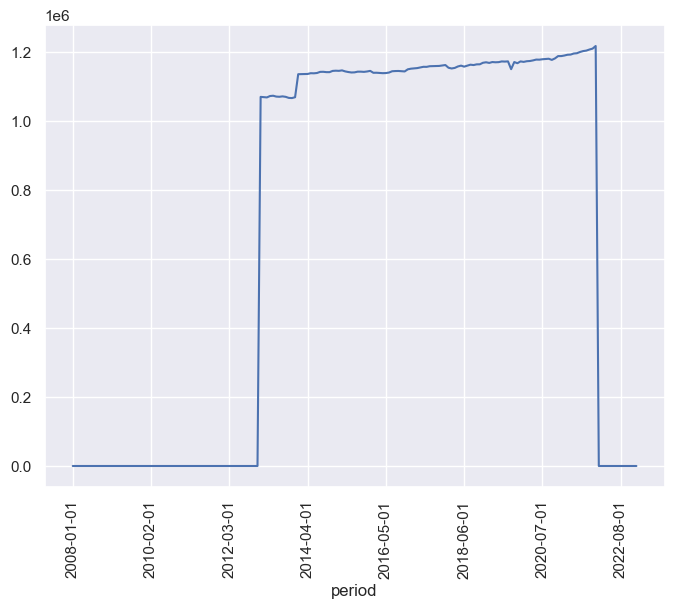

In [535]:
genout_norm.groupby('period')['total_cap_mw'].sum().plot(x='period',y='total_cap_mw', rot=90)

Based on above, suspect missing data in 2022. EIA website states that data is not finalized until the fall following the reporting year.

In [536]:
# remove rows with nonsense generation values (generation exceeds reported capacity)
genout_norm = genout_norm[genout_norm.avg_mw_per_cap <= 1]

In [537]:
genout_norm.head()

,ba_code,period,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap
3598,AEC,2013-01-01,860972.86,453.815890,527.096626,1881.0,0.615216
3599,AECI,2013-01-01,3873454.80,3185.278603,822.335297,6107.4,0.852451
3600,AVA,2013-01-01,1295255.92,131.395915,101.443979,2008.5,0.866784
3601,AZPS,2013-01-01,4218304.56,3977.130799,942.826850,6915.3,0.819887
3602,BANC,2013-01-01,1494348.18,521.837142,349.207199,2762.0,0.727202


Join generation configuration and generation output data frames 

In [538]:
gen_norm = genconf_norm.drop(columns='total_cap_mw').set_index(['ba_code', 'period']).join(genout_norm \
                                                              .set_index(['ba_code', 'period']))

In [539]:
gen_norm.shape

(6996, 30)

In [540]:
gen_norm.head()

av_lat    av_lon       BIT  DFO  GEO   JF  KER  LIG   
ba_code period                                                              
AEC     2013-01-01  0.247954  0.704774  0.286018  0.0  0.0  0.0  0.0  0.0  \
        2013-02-01  0.247954  0.704774  0.286018  0.0  0.0  0.0  0.0  0.0   
        2013-03-01  0.247954  0.704774  0.286018  0.0  0.0  0.0  0.0  0.0   
        2013-04-01  0.247954  0.704774  0.286018  0.0  0.0  0.0  0.0  0.0   
        2013-05-01  0.247954  0.704774  0.286018  0.0  0.0  0.0  0.0  0.0   

                    MSW        NG  ...  TDF       WAT   WC  WND   WO   
ba_code period                     ...                                 
AEC     2013-01-01  0.0  0.707071  ...  0.0  0.004359  0.0  0.0  0.0  \
        2013-02-01  0.0  0.707071  ...  0.0  0.004359  0.0  0.0  0.0   
        2013-03-01  0.0  0.707071  ...  0.0  0.004359  0.0  0.0  0.0   
        2013-04-01  0.0  0.707071  ...  0.0  0.004359  0.0  0.0  0.0   
        2013-05-01  0.0  0.707071  ...  0.0  0.004359  0.0  0.0  0.0   

                      gen_mwh    co2_kton  kg_co2_per_mwh  total_cap_mw   
ba_code period                                                            
AEC     2013-01-01  860972.86  453.815890      527.096626        1881.0  \
        2013-02-01  827951.96  451.042088      544.768428        1881.0   
        2013-03-01  881830.44  473.692029      537.169060        1881.0   
        2013-04-01  660056.56  497.865125      754.276459        1881.0   
        2013-05-01  580954.20  558.151669      960.749865        1881.0   

                    avg_mw_per_cap  
ba_code period                      
AEC     2013-01-01        0.615216  
        2013-02-01        0.591621  
        2013-03-01        0.630120  
        2013-04-01        0.471650  
        2013-05-01        0.415126  

[5 rows x 30 columns]

In [541]:
gen_norm = gen_norm.reset_index()

In [542]:
gen_norm.shape

(6996, 32)

In [543]:
gen_norm.dropna()

,ba_code,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,LIG,...,TDF,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap
0,AEC,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004359,0.0,0.0,0.0,860972.86,453.815890,527.096626,1881.0,0.615216
1,AEC,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004359,0.0,0.0,0.0,827951.96,451.042088,544.768428,1881.0,0.591621
2,AEC,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004359,0.0,0.0,0.0,881830.44,473.692029,537.169060,1881.0,0.630120
3,AEC,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004359,0.0,0.0,0.0,660056.56,497.865125,754.276459,1881.0,0.471650
4,AEC,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004359,0.0,0.0,0.0,580954.20,558.151669,960.749865,1881.0,0.415126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,YAD,2021-08-01,0.428158,0.832558,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,124934.22,0.000000,0.000000,215.2,0.780308
6992,YAD,2021-09-01,0.428158,0.832558,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,152587.44,0.000000,0.000000,215.2,0.953023
6993,YAD,2021-10-01,0.428158,0.832558,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,146708.36,0.000000,0.000000,215.2,0.916304
6994,YAD,2021-11-01,0.428158,0.832558,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,155089.88,0.000000,0.000000,215.2,0.968653


In [544]:
gen_norm.shape

(6996, 32)

In [545]:
ng_price_path = 'NG_price.csv'
ng_price = pd.read_csv(ng_price_path, low_memory=False)
ng_price.head()

,period,NG_price
0,1997-01-01,3.45
1,1997-02-01,2.15
2,1997-03-01,1.89
3,1997-04-01,2.03
4,1997-05-01,2.25


In [546]:
gen_norm = gen_norm.set_index(['period']).join(ng_price.set_index('period')).reset_index()

In [547]:
gen_norm.shape

(6996, 33)

In [548]:
gen_norm.head()

,period,ba_code,av_lat,av_lon,BIT,DFO,GEO,JF,KER,LIG,...,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap,NG_price
0,2013-01-01,AEC,0.247954,0.704774,0.286018,0.000000,0.0,0.0,0.0,0.0,...,0.004359,0.0,0.000000,0.0,860972.86,453.815890,527.096626,1881.0,0.615216,3.33
1,2013-01-01,AECI,0.601319,0.587862,0.000000,0.023496,0.0,0.0,0.0,0.0,...,0.017389,0.0,0.051167,0.0,3873454.80,3185.278603,822.335297,6107.4,0.852451,3.33
2,2013-01-01,AVA,0.953462,0.107131,0.000000,0.001394,0.0,0.0,0.0,0.0,...,0.575952,0.0,0.052427,0.0,1295255.92,131.395915,101.443979,2008.5,0.866784,3.33
3,2013-01-01,AZPS,0.341397,0.199326,0.328200,0.017902,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.025205,0.0,4218304.56,3977.130799,942.826850,6915.3,0.819887,3.33
4,2013-01-01,BANC,0.562624,0.027323,0.000000,0.051919,0.0,0.0,0.0,0.0,...,0.265605,0.0,0.000000,0.0,1494348.18,521.837142,349.207199,2762.0,0.727202,3.33


In [549]:
gen_norm = gen_norm.dropna()

In [550]:
gen_norm.shape

(5523, 33)

In [551]:
gen_norm = gen_norm.reset_index()
gen_norm.head()

,index,period,ba_code,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap,NG_price
0,0,2013-01-01,AEC,0.247954,0.704774,0.286018,0.000000,0.0,0.0,0.0,...,0.004359,0.0,0.000000,0.0,860972.86,453.815890,527.096626,1881.0,0.615216,3.33
1,1,2013-01-01,AECI,0.601319,0.587862,0.000000,0.023496,0.0,0.0,0.0,...,0.017389,0.0,0.051167,0.0,3873454.80,3185.278603,822.335297,6107.4,0.852451,3.33
2,2,2013-01-01,AVA,0.953462,0.107131,0.000000,0.001394,0.0,0.0,0.0,...,0.575952,0.0,0.052427,0.0,1295255.92,131.395915,101.443979,2008.5,0.866784,3.33
3,3,2013-01-01,AZPS,0.341397,0.199326,0.328200,0.017902,0.0,0.0,0.0,...,0.000000,0.0,0.025205,0.0,4218304.56,3977.130799,942.826850,6915.3,0.819887,3.33
4,4,2013-01-01,BANC,0.562624,0.027323,0.000000,0.051919,0.0,0.0,0.0,...,0.265605,0.0,0.000000,0.0,1494348.18,521.837142,349.207199,2762.0,0.727202,3.33


In [552]:
gen_norm.shape

(5523, 34)

In [553]:
move_col = gen_norm.pop('ba_code')
gen_norm.insert(0, move_col.name, move_col)
gen_norm.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,avg_mw_per_cap,NG_price
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.000000,0.0,0.0,0.0,...,0.004359,0.0,0.000000,0.0,860972.86,453.815890,527.096626,1881.0,0.615216,3.33
1,AECI,1,2013-01-01,0.601319,0.587862,0.000000,0.023496,0.0,0.0,0.0,...,0.017389,0.0,0.051167,0.0,3873454.80,3185.278603,822.335297,6107.4,0.852451,3.33
2,AVA,2,2013-01-01,0.953462,0.107131,0.000000,0.001394,0.0,0.0,0.0,...,0.575952,0.0,0.052427,0.0,1295255.92,131.395915,101.443979,2008.5,0.866784,3.33
3,AZPS,3,2013-01-01,0.341397,0.199326,0.328200,0.017902,0.0,0.0,0.0,...,0.000000,0.0,0.025205,0.0,4218304.56,3977.130799,942.826850,6915.3,0.819887,3.33
4,BANC,4,2013-01-01,0.562624,0.027323,0.000000,0.051919,0.0,0.0,0.0,...,0.265605,0.0,0.000000,0.0,1494348.18,521.837142,349.207199,2762.0,0.727202,3.33


In [554]:
gen_norm.columns

Index(['ba_code', 'index', 'period', 'av_lat', 'av_lon', 'BIT', 'DFO', 'GEO',
       'JF', 'KER', 'LIG', 'MSW', 'NG', 'NUC', 'OTH', 'PC', 'PG', 'RC', 'RFO',
       'SGC', 'SGP', 'SUB', 'SUN', 'TDF', 'WAT', 'WC', 'WND', 'WO', 'gen_mwh',
       'co2_kton', 'kg_co2_per_mwh', 'total_cap_mw', 'avg_mw_per_cap',
       'NG_price'],
      dtype='object')

In [555]:
move_col = gen_norm.pop('NG_price')
gen_norm.insert(gen_norm.columns.get_loc('avg_mw_per_cap'), move_col.name, move_col)
gen_norm.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,NG_price,avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.000000,0.0,0.0,0.0,...,0.004359,0.0,0.000000,0.0,860972.86,453.815890,527.096626,1881.0,3.33,0.615216
1,AECI,1,2013-01-01,0.601319,0.587862,0.000000,0.023496,0.0,0.0,0.0,...,0.017389,0.0,0.051167,0.0,3873454.80,3185.278603,822.335297,6107.4,3.33,0.852451
2,AVA,2,2013-01-01,0.953462,0.107131,0.000000,0.001394,0.0,0.0,0.0,...,0.575952,0.0,0.052427,0.0,1295255.92,131.395915,101.443979,2008.5,3.33,0.866784
3,AZPS,3,2013-01-01,0.341397,0.199326,0.328200,0.017902,0.0,0.0,0.0,...,0.000000,0.0,0.025205,0.0,4218304.56,3977.130799,942.826850,6915.3,3.33,0.819887
4,BANC,4,2013-01-01,0.562624,0.027323,0.000000,0.051919,0.0,0.0,0.0,...,0.265605,0.0,0.000000,0.0,1494348.18,521.837142,349.207199,2762.0,3.33,0.727202


In [556]:
# normalize natural gas price
gen_norm['NG_price'] = (gen_norm['NG_price'] - gen_norm['NG_price'].min())/(gen_norm['NG_price'].max() \
    - gen_norm['NG_price'].min())

In [557]:
gen_norm.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,WAT,WC,WND,WO,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,NG_price,avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.000000,0.0,0.0,0.0,...,0.004359,0.0,0.000000,0.0,860972.86,453.815890,527.096626,1881.0,0.389016,0.615216
1,AECI,1,2013-01-01,0.601319,0.587862,0.000000,0.023496,0.0,0.0,0.0,...,0.017389,0.0,0.051167,0.0,3873454.80,3185.278603,822.335297,6107.4,0.389016,0.852451
2,AVA,2,2013-01-01,0.953462,0.107131,0.000000,0.001394,0.0,0.0,0.0,...,0.575952,0.0,0.052427,0.0,1295255.92,131.395915,101.443979,2008.5,0.389016,0.866784
3,AZPS,3,2013-01-01,0.341397,0.199326,0.328200,0.017902,0.0,0.0,0.0,...,0.000000,0.0,0.025205,0.0,4218304.56,3977.130799,942.826850,6915.3,0.389016,0.819887
4,BANC,4,2013-01-01,0.562624,0.027323,0.000000,0.051919,0.0,0.0,0.0,...,0.265605,0.0,0.000000,0.0,1494348.18,521.837142,349.207199,2762.0,0.389016,0.727202


In [558]:
gen_norm = gen_norm.sort_values(by=['ba_code','period'])

In [559]:
gen_norm = gen_norm[gen_norm.kg_co2_per_mwh >= 0]

<Axes: xlabel='period'>

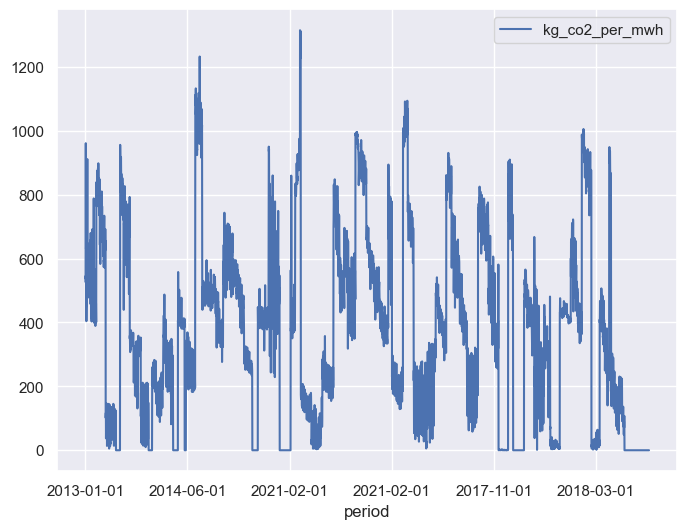

In [560]:
gen_norm.plot(x='period',y='kg_co2_per_mwh')

In [561]:
# drop outlier carbon intensity values
#gen_norm = gen_norm.drop(gen_norm[gen_norm.kg_co2_per_mwh > 1000].index)

<Axes: xlabel='period'>

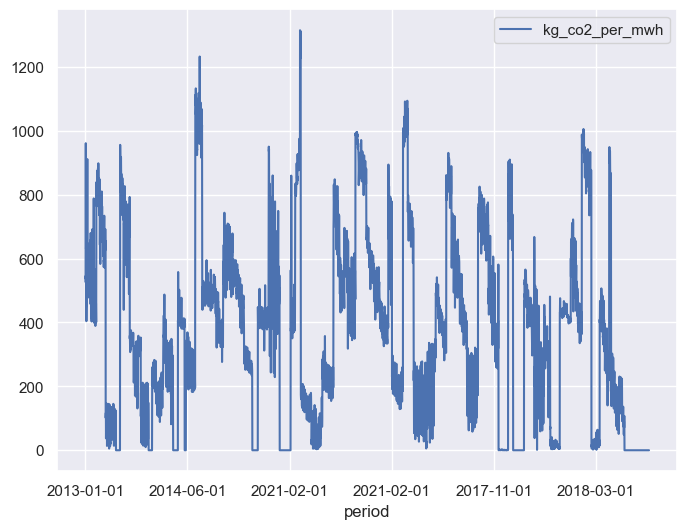

In [562]:
gen_norm.plot(x='period',y='kg_co2_per_mwh')

Use Fast Fourier Transform to check for actual seasonality in the response variable

In [563]:
ci_monthly = gen_norm.groupby('period')['kg_co2_per_mwh'].mean()
ci_monthly.head()

period
2013-01-01    421.822934
2013-02-01    420.923732
2013-03-01    413.834138
2013-04-01    428.206847
2013-05-01    424.267633
Name: kg_co2_per_mwh, dtype: float64

In [564]:
type(ci_monthly)

pandas.core.series.Series

Text(0.5, 0, '# Cycles in full window of data (~5 years)')

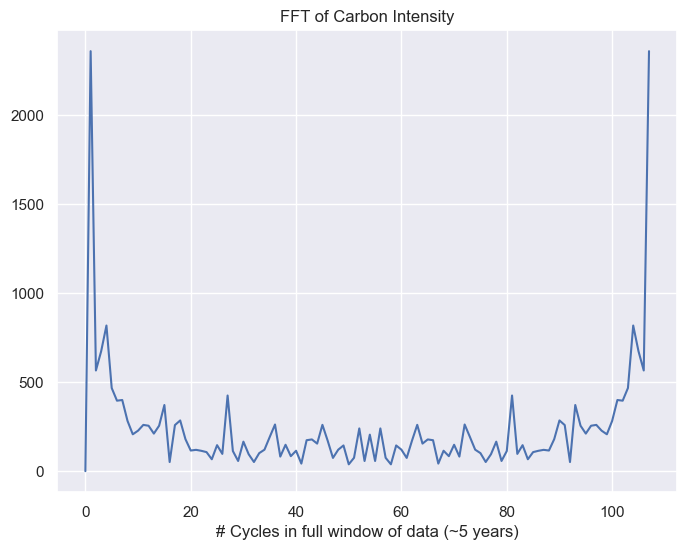

In [565]:
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt

# apply FFT to emissions intensity deviation from mean
fft_ci = fft((ci_monthly - ci_monthly.mean()).values)

# plot emissions intensity deviation in frequency domain
plt.plot(np.abs(fft_ci))
plt.title("FFT of Carbon Intensity")
plt.xlabel('# Cycles in full window of data (~5 years)')

Text(0.5, 0, 'Frequency ($y^{-1}$)')

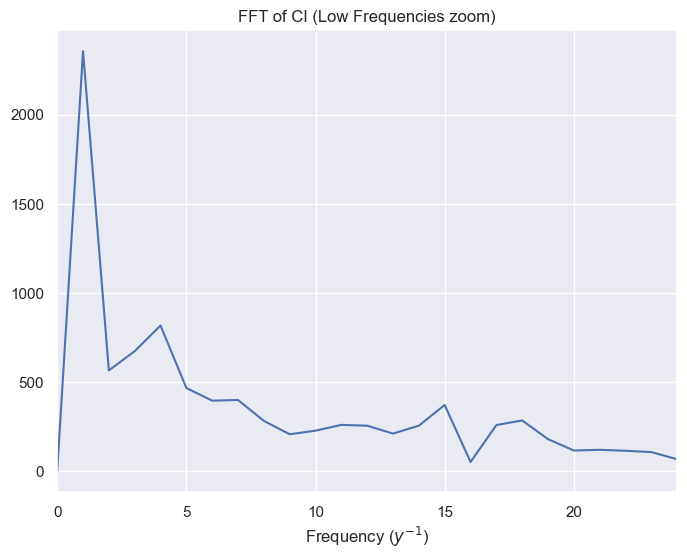

In [566]:
# zoom on sub-annual frequencies
plt.plot(np.abs(fft_ci))
plt.title("FFT of CI (Low Frequencies zoom)")
plt.xlim([0,24])
plt.xlabel('Frequency ($y^{-1}$)')

Add features to reflect hypothesized annual and 6-month seasonality. Seasonal variations are expected in solar irradiance (annual cycle) and demand (~6-month cycle due to heating demand in winter and cooling demand in summer)

In [567]:
gen_norm['period'] = pd.to_datetime(gen_norm['period'])
# create Julian date column (days since noon on 1 Jan 4713 BC)
gen_norm['julian'] = gen_norm['period'].apply(lambda x : pd.Timestamp(x).to_julian_date())
# create sine and cosine of time features
gen_norm['sin_year'] = np.sin(gen_norm['julian'] / 365.25 * 2 * np.pi)
gen_norm['cos_year'] = np.cos(gen_norm['julian'] / 365.25 * 2 * np.pi)
gen_norm['sin_6mo'] = np.sin(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
gen_norm['cos_6mo'] = np.cos(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
gen_norm = gen_norm.drop(columns=['julian'])

Examine features graphically

In [568]:
gen_norm.columns

Index(['ba_code', 'index', 'period', 'av_lat', 'av_lon', 'BIT', 'DFO', 'GEO',
       'JF', 'KER', 'LIG', 'MSW', 'NG', 'NUC', 'OTH', 'PC', 'PG', 'RC', 'RFO',
       'SGC', 'SGP', 'SUB', 'SUN', 'TDF', 'WAT', 'WC', 'WND', 'WO', 'gen_mwh',
       'co2_kton', 'kg_co2_per_mwh', 'total_cap_mw', 'NG_price',
       'avg_mw_per_cap', 'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo'],
      dtype='object')

In [569]:
test = list(gen_norm.columns.values)
test

['ba_code',
 'index',
 'period',
 'av_lat',
 'av_lon',
 'BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'gen_mwh',
 'co2_kton',
 'kg_co2_per_mwh',
 'total_cap_mw',
 'NG_price',
 'avg_mw_per_cap',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo']

In [570]:
not_features = ['ba_code', 'index', 'period', 'kg_co2_per_mwh', 'gen_mwh', 'co2_kton', 'total_cap_mw',]
X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
X_names

['av_lat',
 'av_lon',
 'BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'NG_price',
 'avg_mw_per_cap',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo']

C:\Users\lilye\AppData\Local\Temp\ipykernel_25184\2468694431.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


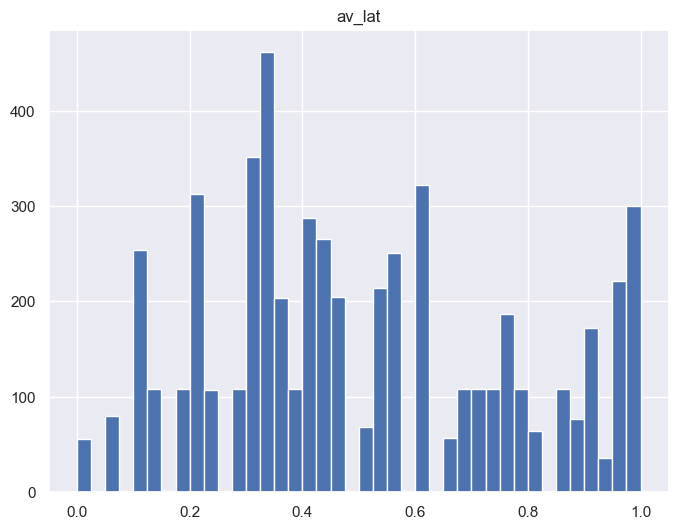

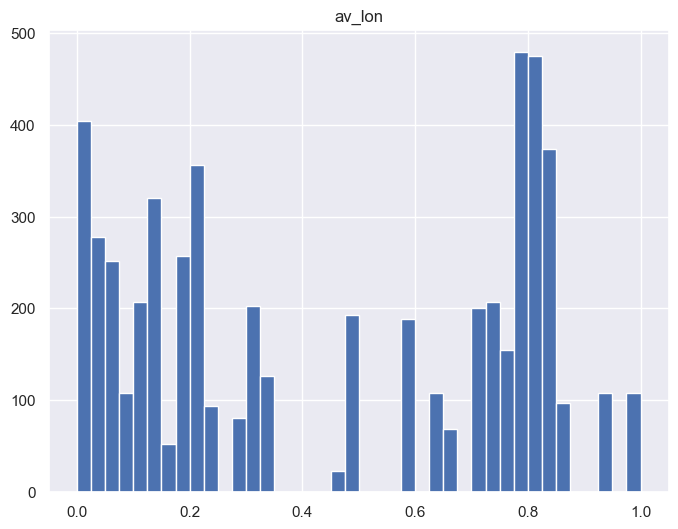

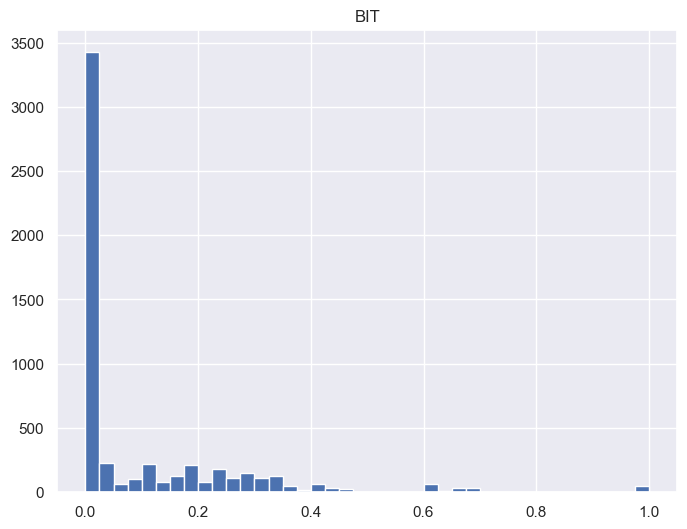

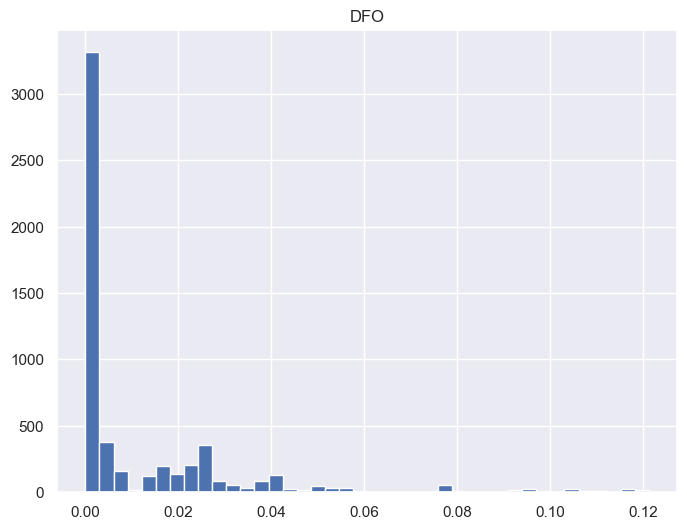

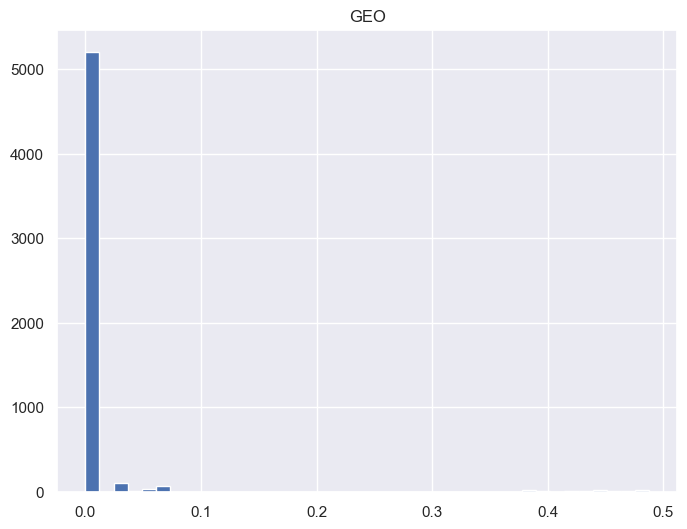

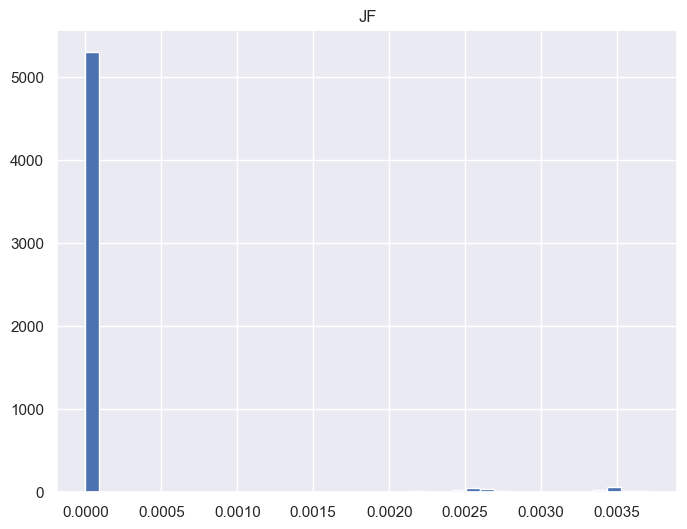

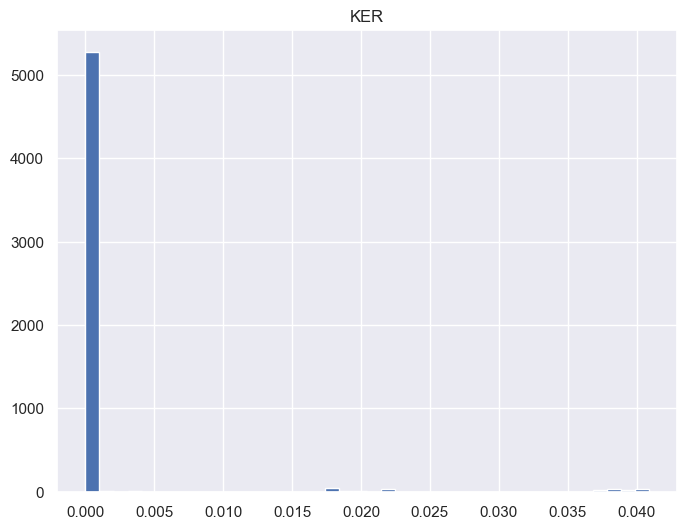

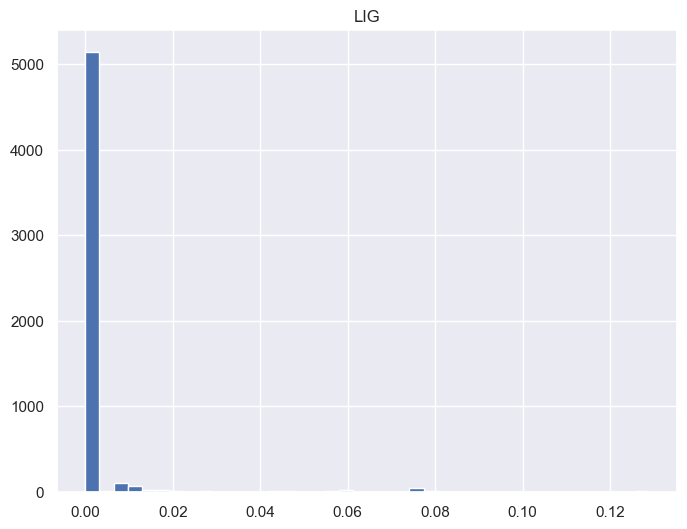

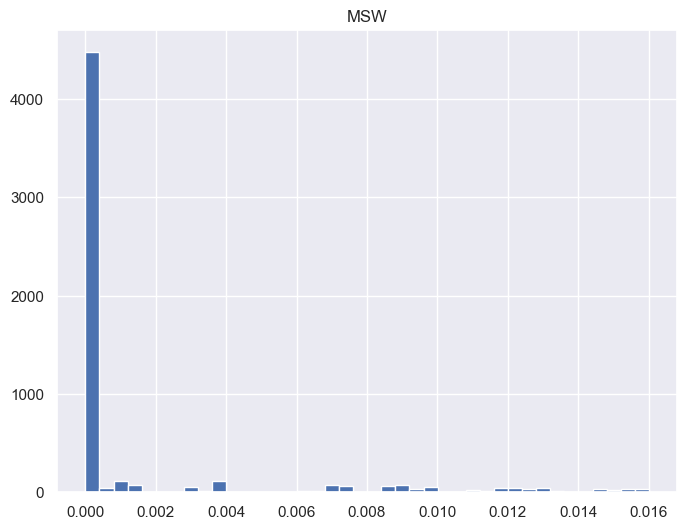

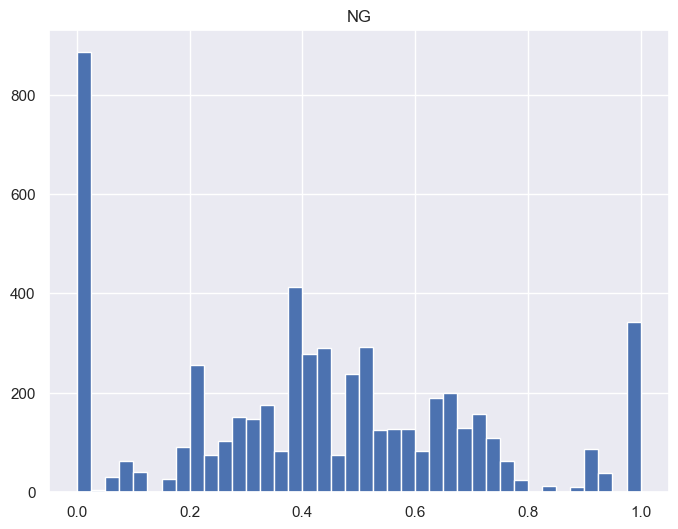

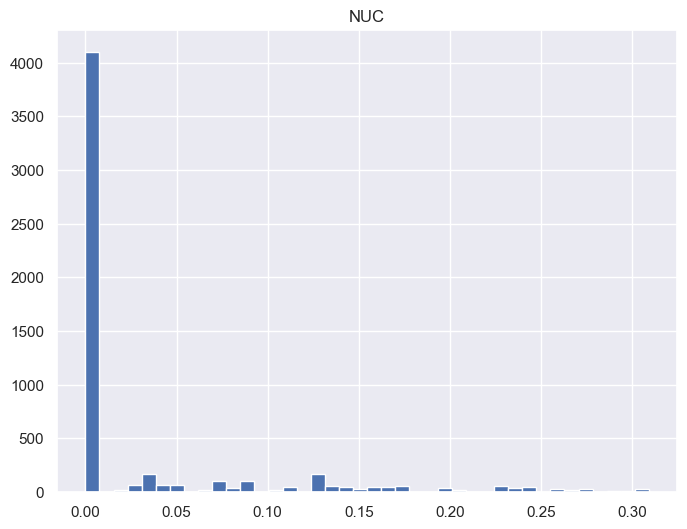

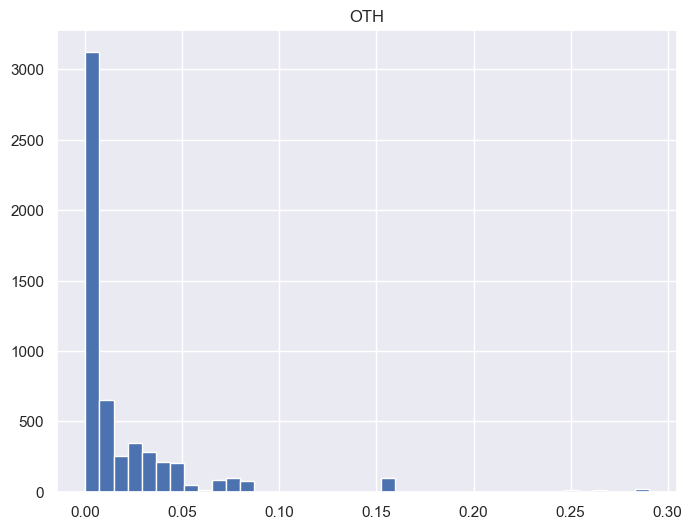

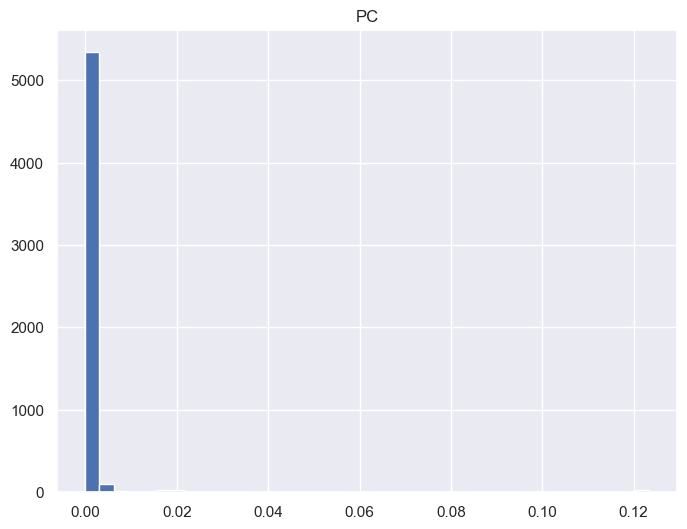

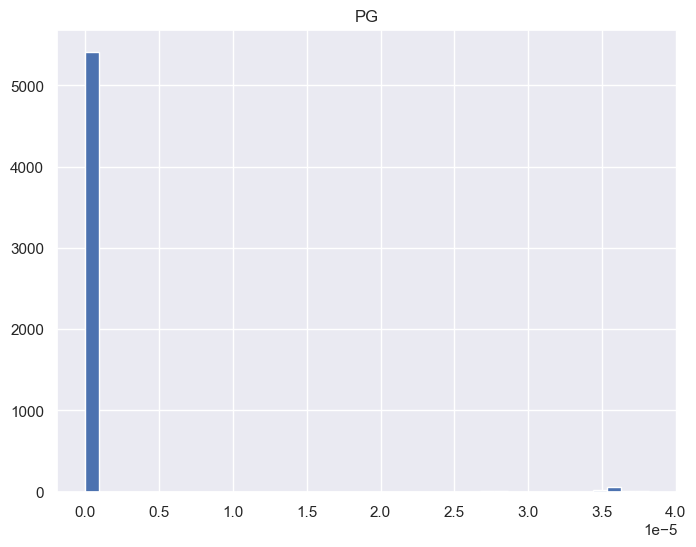

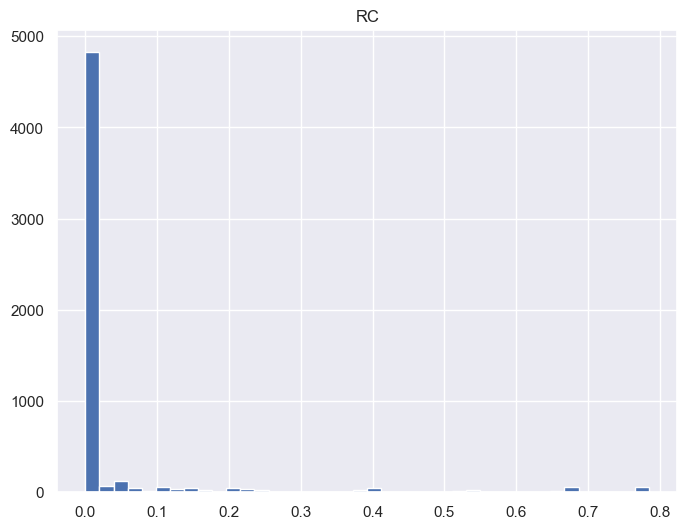

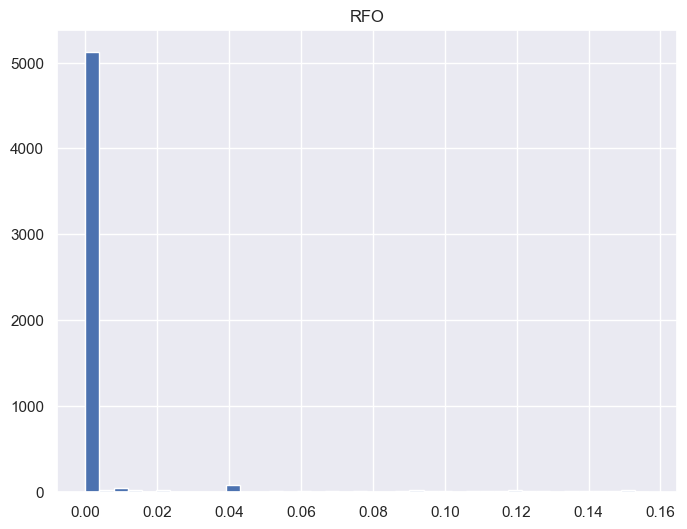

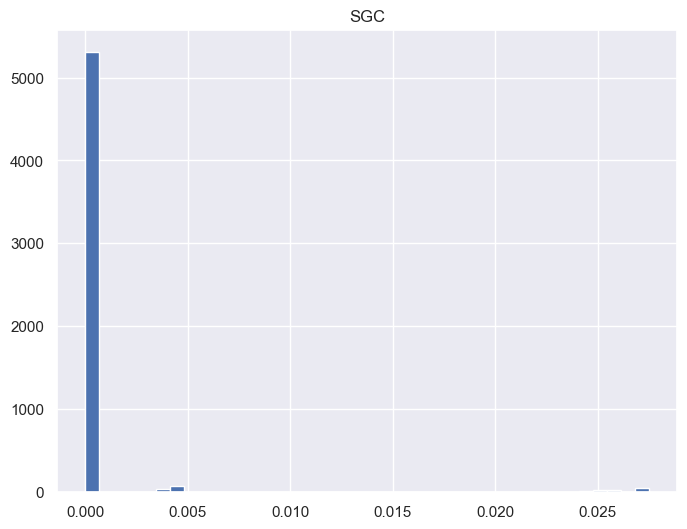

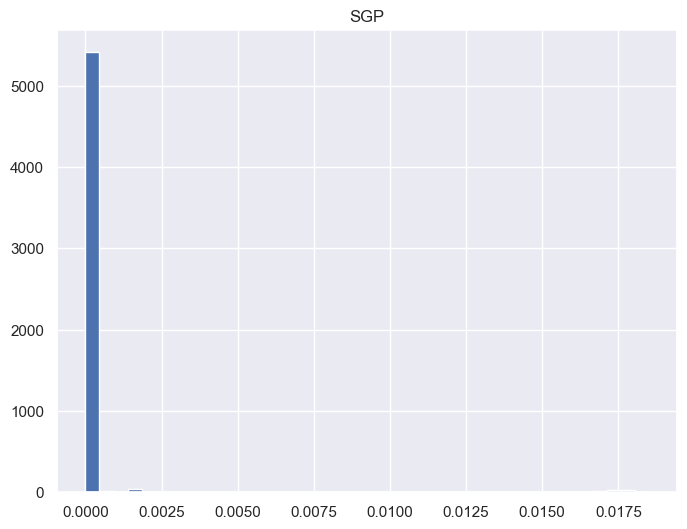

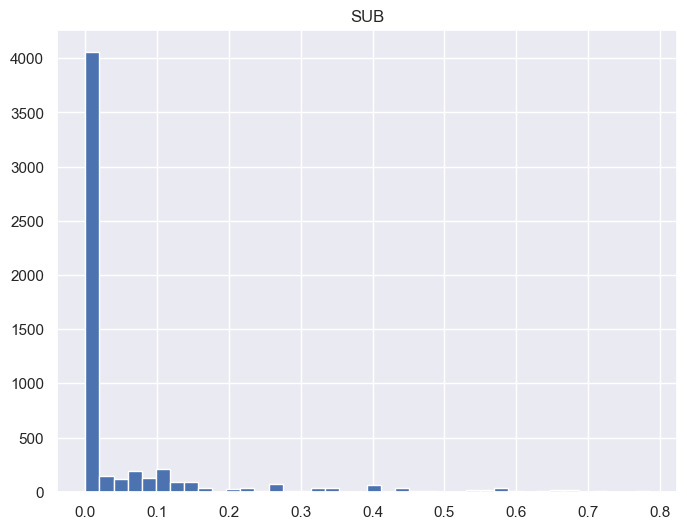

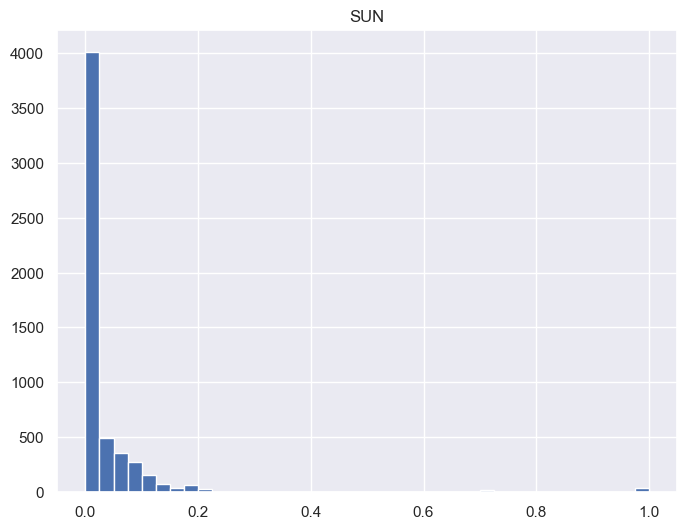

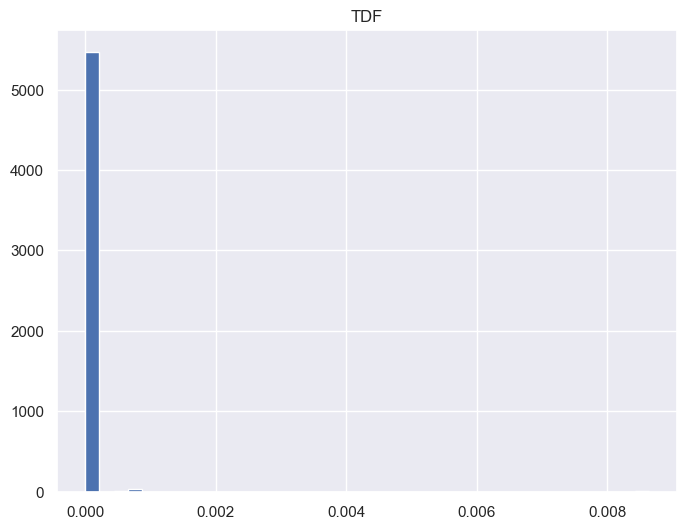

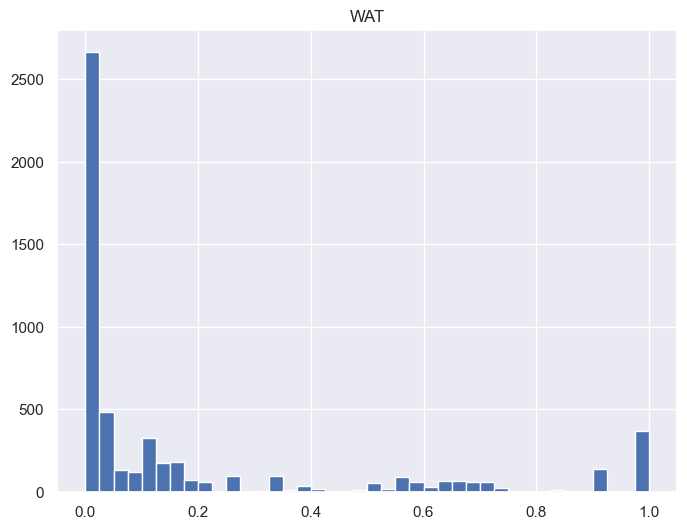

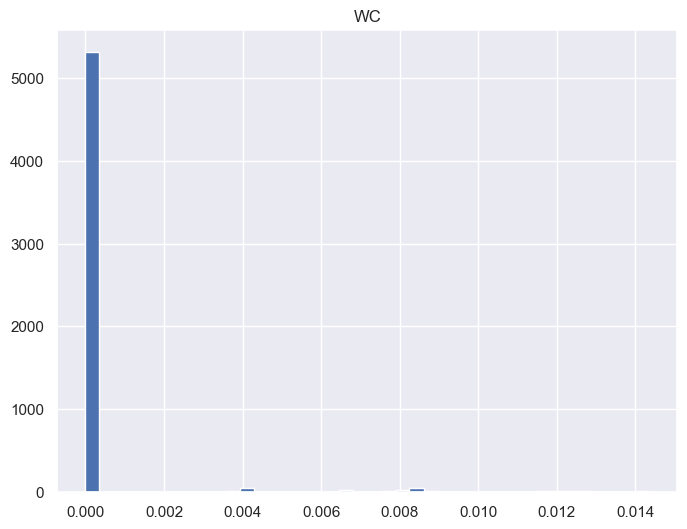

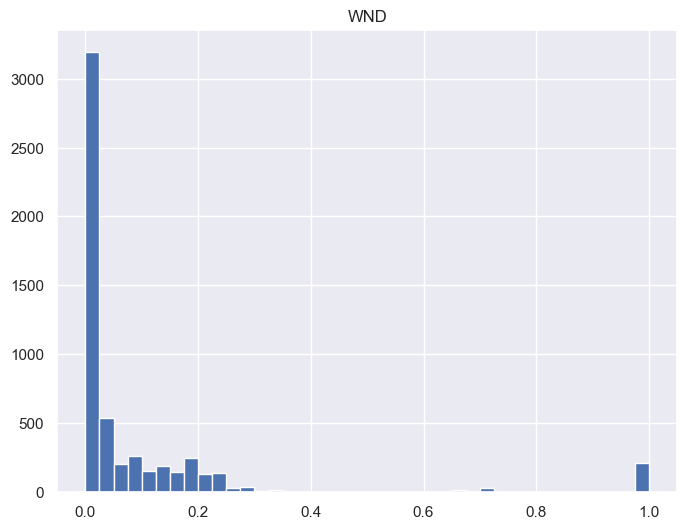

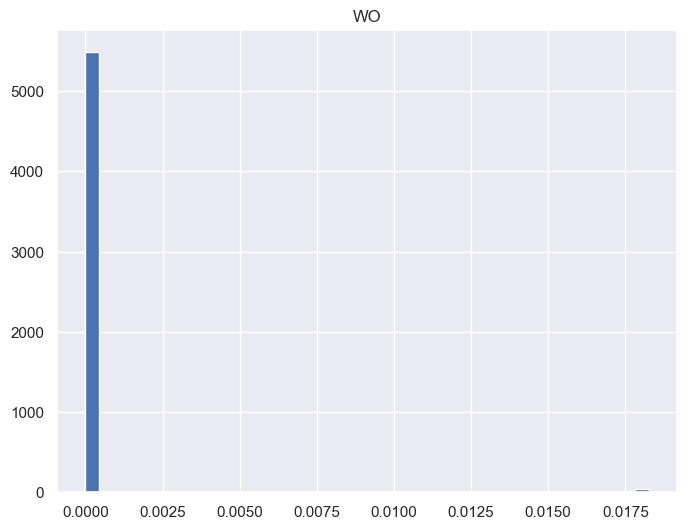

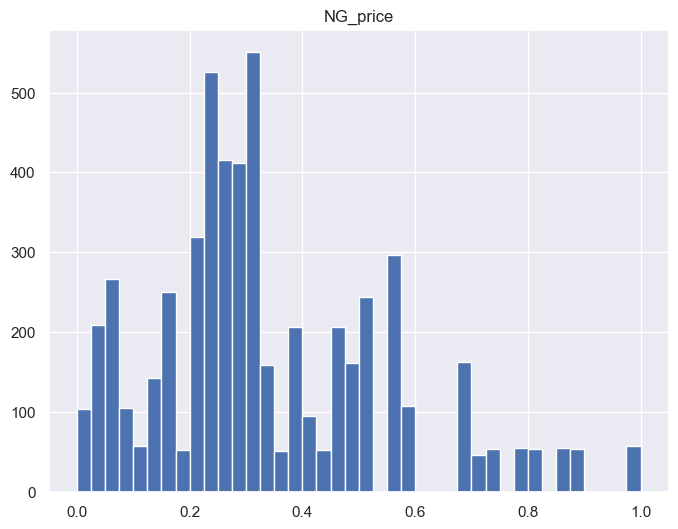

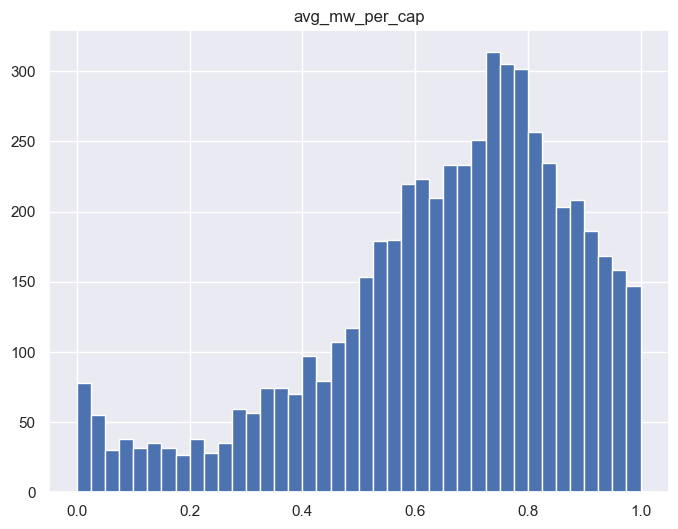

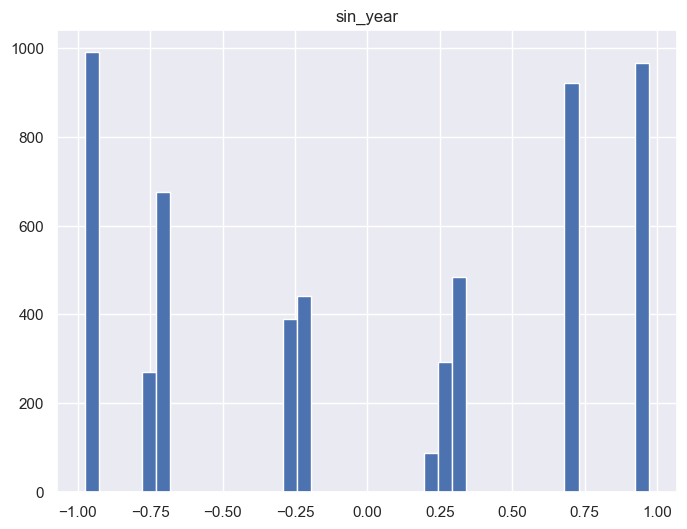

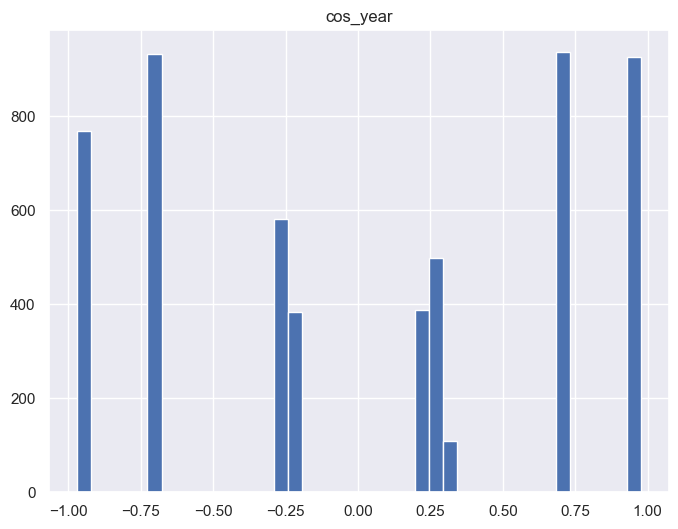

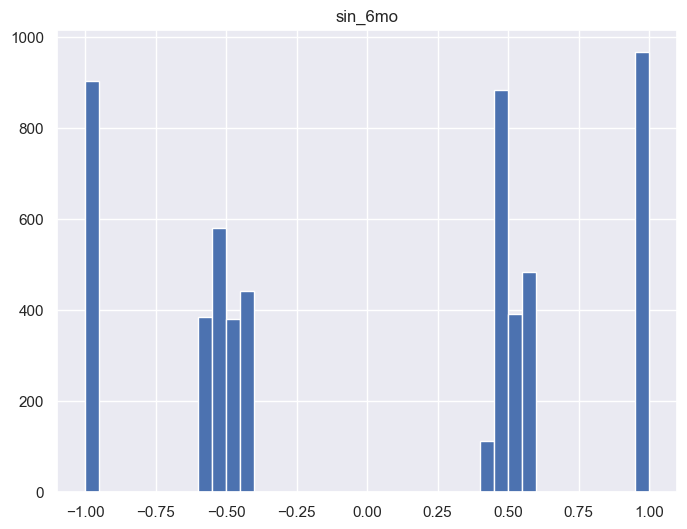

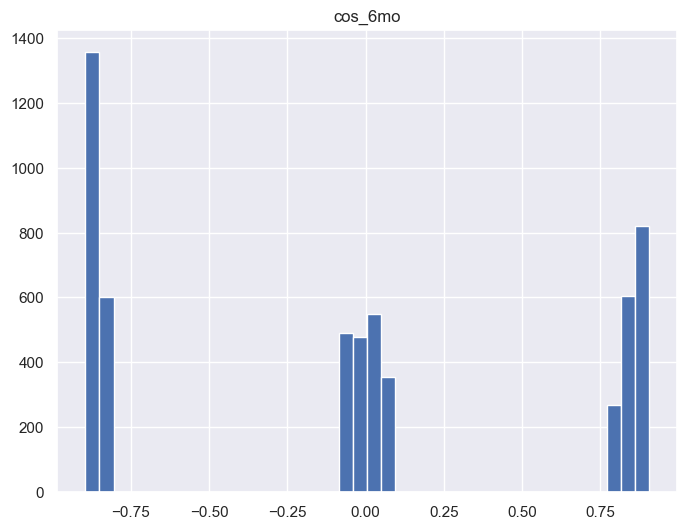

In [571]:

for X in X_names:
    plt.figure()
    plt.title(X)
    plt.hist(gen_norm[X], bins=40)


In [572]:
gen_norm.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,gen_mwh,co2_kton,kg_co2_per_mwh,total_cap_mw,NG_price,avg_mw_per_cap,sin_year,cos_year,sin_6mo,cos_6mo
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,860972.86,453.815890,527.096626,1881.0,0.389016,0.615216,-0.217577,0.976043,-0.424728,0.905321
50,AEC,63,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,827951.96,451.042088,544.768428,1881.0,0.389016,0.591621,0.308812,0.951123,0.587437,0.809270
104,AEC,126,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,881830.44,473.692029,537.169060,1881.0,0.498856,0.630120,0.714292,0.699848,0.999791,-0.020426
156,AEC,189,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,660056.56,497.865125,754.276459,1881.0,0.581236,0.471650,0.970882,0.239557,0.465162,-0.885225
211,AEC,252,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,580954.20,558.151669,960.749865,1881.0,0.551487,0.415126,0.962652,-0.270742,-0.521260,-0.853398


Most features appear right-skewed. Apply log transform using log(1+X). Avoids undefined result at log(0).

In [573]:
import numpy as np

# list feature names to log transform
no_log = ['av_lat', 'av_lon', 'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo']
X_to_log = [i for i in X_names if i not in no_log]
X_log_names = [f"log_{i}" for i in X_to_log]
gen_norm[X_log_names] = gen_norm[X_to_log].apply(lambda x: np.log(1+x))
gen_norm.head()


,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.479469
50,AEC,63,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.464753
104,AEC,126,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.404702,0.488654
156,AEC,189,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.458207,0.386384
211,AEC,252,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.439214,0.347219


In [574]:
# one hot encode by BA
#gen_norm['ba'] = gen_norm['ba_code']
#gen_norm = pd.get_dummies(gen_norm, columns=['ba'], dtype=np.uint8)

In [575]:
gen_norm.head()

,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.479469
50,AEC,63,2013-02-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.328596,0.464753
104,AEC,126,2013-03-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.404702,0.488654
156,AEC,189,2013-04-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.458207,0.386384
211,AEC,252,2013-05-01,0.247954,0.704774,0.286018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00435,0.0,0.0,0.0,0.439214,0.347219


Correlation Matrix

<Axes: >

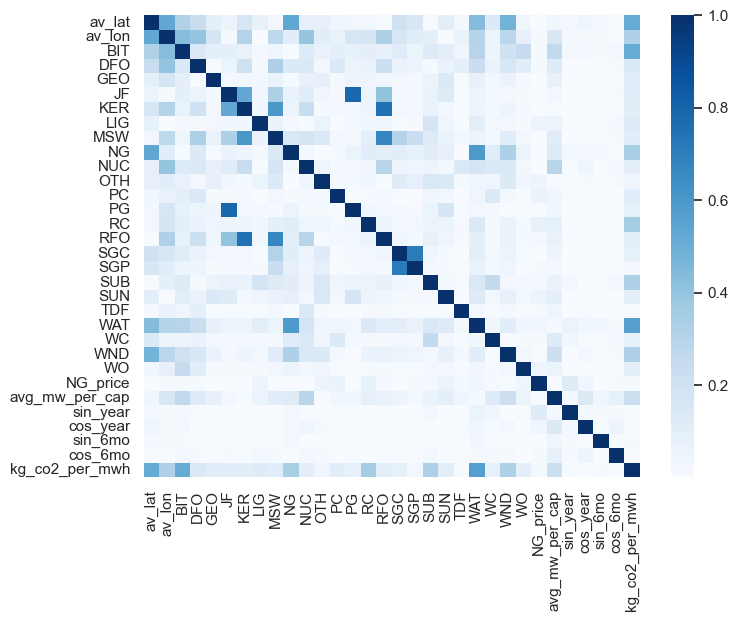

In [576]:
import seaborn as sns

sns.heatmap(data=abs(gen_norm[X_names + ['kg_co2_per_mwh']].corr(numeric_only=True)), cmap='Blues', xticklabels=True, yticklabels=True)

Select feature names manually

In [577]:
X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
X_names

['av_lat',
 'av_lon',
 'BIT',
 'DFO',
 'GEO',
 'JF',
 'KER',
 'LIG',
 'MSW',
 'NG',
 'NUC',
 'OTH',
 'PC',
 'PG',
 'RC',
 'RFO',
 'SGC',
 'SGP',
 'SUB',
 'SUN',
 'TDF',
 'WAT',
 'WC',
 'WND',
 'WO',
 'NG_price',
 'avg_mw_per_cap',
 'sin_year',
 'cos_year',
 'sin_6mo',
 'cos_6mo',
 'log_BIT',
 'log_DFO',
 'log_GEO',
 'log_JF',
 'log_KER',
 'log_LIG',
 'log_MSW',
 'log_NG',
 'log_NUC',
 'log_OTH',
 'log_PC',
 'log_PG',
 'log_RC',
 'log_RFO',
 'log_SGC',
 'log_SGP',
 'log_SUB',
 'log_SUN',
 'log_TDF',
 'log_WAT',
 'log_WC',
 'log_WND',
 'log_WO',
 'log_NG_price',
 'log_avg_mw_per_cap']

<Axes: >

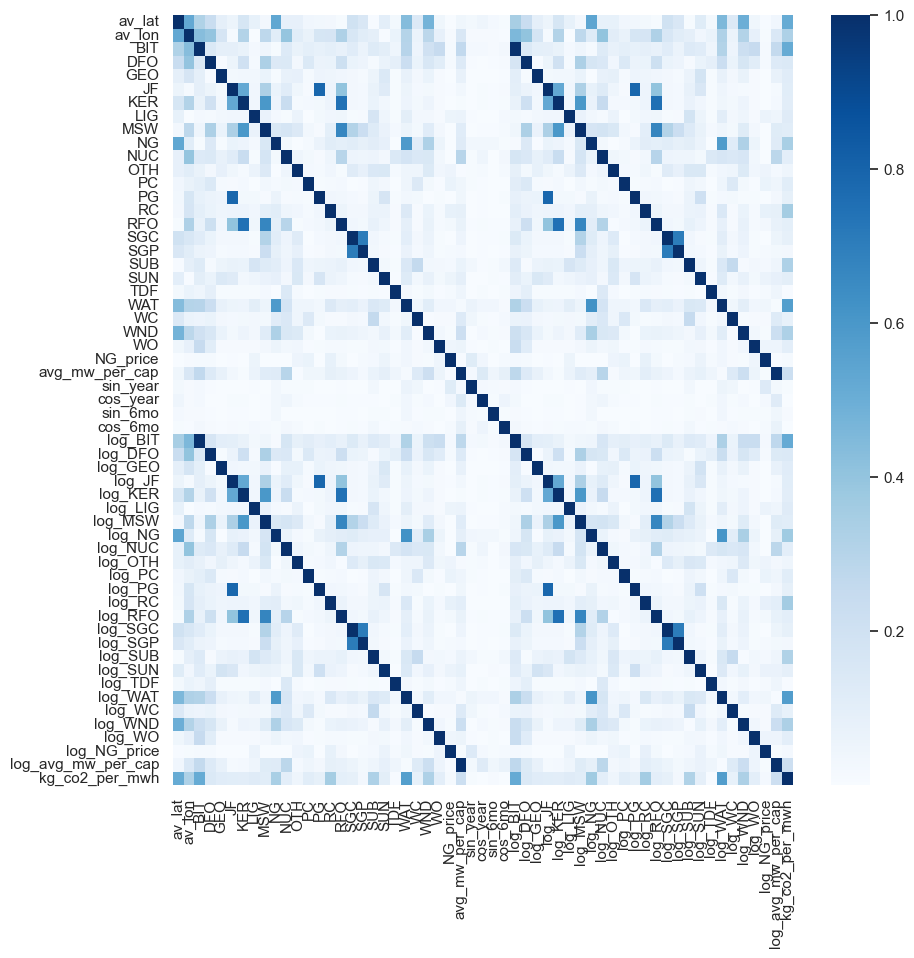

In [578]:
import seaborn as sns

sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(data=abs(gen_norm[X_names + ['kg_co2_per_mwh']].corr(numeric_only=True)), cmap='Blues', xticklabels=True, yticklabels=True)

In [579]:
gen_norm.shape

(5523, 63)

In [580]:
len(X_names)

56

## Models
### Linear Regression
### Random Forest Regression with hyperparameter optimization and cross validation
### XGBoost Regression with hyperparameter optimization and cross validation
 * Response variable is CO2 Intensity (kg CO2 per MW-hr generated)
 * Explanatory variables are selected features in the following categories: generator configuration (installed capacity by fuel source), specific power, location (geographical average for BA), seasonality, fuel price (natural gas only), BA (categorical)

In [581]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
from xgboost import XGBRegressor

def trainLinear(X_train, y_train):
    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)
    return linearModel

def rfrBaseline(X_train, y_train, rand_st):
    rfr_base = RandomForestRegressor(max_depth=2, min_samples_split=2, n_estimators = 100, random_state=rand_st)
    rfr_base.fit(X_train, y_train)
    return rfr_base

def xgrBaseline(X_train, y_train, rand_st):
    xgr_base = XGBRegressor(max_depth=2, subsample=0.7, colsample_bytree=0.8, eta=0.1, n_estimators = 1000 \
                            , random_state=rand_st)
    xgr_base.fit(X_train, y_train)
    return xgr_base

def rfrTrainTune(X_train, y_train, rand_st):
    rfr = RandomForestRegressor()
    # n_estimators, max_depth, min_samples_split, and max_features are chosen as hyperparameters
    rs = RandomizedSearchCV(rfr, n_iter=10, param_distributions={'n_estimators': range(50,150,5) \
                        , 'max_depth': range(1,30) \
                        , 'min_samples_split':range(2,30) \
                        , 'max_features': ['sqrt', 'log2', None]} \
                        , cv=5, n_jobs=-1, random_state=rand_st)
    rs.fit(X_train, y_train)
    print(f"rs best params:  {rs.best_params_}")
    print(f"rs best score  {rs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    rfr_tuned = RandomForestRegressor(**rs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    rfr_tuned.fit(X_train, y_train)
    return rfr_tuned, rs.best_params_

def xgrTrainTune(X_train, y_train, param_distributions, rand_st):
    xgr = XGBRegressor()
    rs = RandomizedSearchCV(xgr, n_iter=10, param_distributions=param_distributions \
                        , cv=5, n_jobs=-1, random_state=rand_st)
    rs.fit(X_train, y_train)
    print(f"rs best params:  {rs.best_params_}")
    print(f"rs best score  {rs.best_score_}")
    # apply best hyperparameter values to xgboost regression model
    xgr_tuned = XGBRegressor(**rs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    xgr_tuned.fit(X_train, y_train)
    return xgr_tuned, rs.best_params_

'''
def rfrParamGrid(coarse_params):
    grid_start = 0.9
    grid_stop = 1.1
    grid_cells_max = 5
    param_grid = {}
    for k in coarse_params.keys():
        try:
            start = math.floor(coarse_params[k]*grid_start)
            if start == 0:
                start = 1
            stop = math.ceil(coarse_params[k]*grid_stop)
            step = math.ceil((stop - start) / grid_cells_max)
            param_grid[k] = range(start,stop,step)
        except TypeError:
            param_grid[k] = [coarse_params[k]]
    print(f"parameter grid:  {param_grid}")
    return param_grid
'''

def createParamGrid(coarse_params, grid_cells_max):
    grid_start = 0.9
    grid_stop = 1.1
    param_grid = {}
    for k in coarse_params.keys():
        try:
            if isinstance(coarse_params[k], int):
                start = math.floor(coarse_params[k]*grid_start)
                if start == 0:
                    start = 1
                stop = math.ceil(coarse_params[k]*grid_stop)
                step = math.ceil((stop - start) / grid_cells_max)
                param_grid[k] = list(set(np.linspace(start, stop, num=grid_cells_max, dtype=int)))
            else:
                start = coarse_params[k]*grid_start
                stop = coarse_params[k]*grid_stop
                step = (stop - start) / grid_cells_max
                param_grid[k] = np.linspace(start,stop,num=grid_cells_max)
        except TypeError:
            param_grid[k] = [coarse_params[k]]
    print(f"parameter grid:  {param_grid}")
    return param_grid

def rfrFineTune(X_train, y_train, param_grid, rand_st):
    rfr = RandomForestRegressor()
    gs = GridSearchCV(rfr, param_grid = param_grid, cv=3, n_jobs=-1, verbose = 2)
    gs.fit(X_train, y_train)
    print(f"grid search best params:  {gs.best_params_}")
    print(f"grid search best score  {gs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    rfr_finetuned = RandomForestRegressor(**gs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    rfr_finetuned.fit(X_train, y_train)
    return rfr_finetuned  

def xgrFineTune(X_train, y_train, param_grid, rand_st):
    xgr = XGBRegressor()
    gs = GridSearchCV(xgr, param_grid = param_grid, cv=3, n_jobs=-1, verbose = 2)
    gs.fit(X_train, y_train)
    print(f"grid search best params:  {gs.best_params_}")
    print(f"grid search best score  {gs.best_score_}")
    # apply best hyperparameter values to random forest regression model
    xgr_finetuned = XGBRegressor(**gs.best_params_, random_state=rand_st)
    # fit tuned model to data set 
    xgr_finetuned.fit(X_train, y_train)
    return xgr_finetuned

def regrTest(regr_model, X_test, y_test):
    y_pred = regr_model.predict(X_test)
    print("Model Performance:")
    print('    Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
    print('    Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
    print('    Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, y_pred, squared=False))
    print('    Mean Absolute Percentage Error (MAPE):', 100 * metrics.mean_absolute_percentage_error(y_test, y_pred))
    print('    Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
    print('    Max Error:', metrics.max_error(y_test, y_pred))
    #print('    Mean Squared Log Error:', metrics.mean_squared_log_error(y_test, y_pred))
    print('    Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
    print('    R^2:', metrics.r2_score(y_test, y_pred))
    #print('    Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_test, y_pred))
    #print(    'Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_test, y_pred))
    return metrics.explained_variance_score(y_test, y_pred)
    


In [582]:
X = gen_norm[X_names]
y = gen_norm['kg_co2_per_mwh']
rand_st = 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=rand_st, shuffle=True)

print("Baseline Linear Regression Model")
lr_base = trainLinear(X_train, y_train)
lr_base_score = regrTest(lr_base, X_test, y_test)
print("Baseline Random Forest Regression Model")
rfr_base = rfrBaseline(X_train, y_train, rand_st)
rfr_base_score = regrTest(rfr_base, X_test, y_test)
print("RFR Tuned with Randomized Search CV")
rfr_tuned, rs_params = rfrTrainTune(X_train, y_train, rand_st)
rfr_tuned_score = regrTest(rfr_tuned, X_test, y_test)
print("RFR Fine-tuned with Grid Search CV")
param_grid = createParamGrid(rs_params, 5)
rfr_finetuned = rfrFineTune(X_train, y_train, param_grid, rand_st)
rfr_finetuned_score = regrTest(rfr_finetuned, X_test, y_test)

print("Baseline XGBoost Regression Model")
xgr_base = xgrBaseline(X_train, y_train, rand_st)
xgr_base_score = regrTest(xgr_base, X_test, y_test)
print("XGBoost Regression Tuned with Randomized Search CV")
param_distributions = {'n_estimators': range(500,1500,50) \
                        , 'max_depth': range(1,30) \
                        , 'subsample': np.arange(0.5,1.0,0.1) \
                        , 'colsample_bytree': np.arange(0.5,1.0,0.1) \
                        , 'eta': np.arange(0.01,0.31,0.05)}
xgr_tuned, rs_params = xgrTrainTune(X_train, y_train, param_distributions, rand_st)
xgr_tuned_score = regrTest(xgr_tuned, X_test, y_test)
#print("XGBoost Regression Fine-tuned with Randomized Search CV zoomed on hyperparameters")
#param_distributions = createParamGrid(rs_params, 5)
#xgr_finetuned, rs_params_fine = xgrTrainTune(X_train, y_train, param_distributions, rand_st)
#print("XGBR Fine-tuned with Grid Search CV")
#param_grid = createParamGrid(rs_params, 3)
#xgr_finetuned = xgrFineTune(X_train, y_train, param_grid)
#xgr_finetuned_score = regrTest(xgr_finetuned, X_test, y_test)


Baseline Linear Regression Model
Model Performance:
    Mean Squared Error (MSE): 8491.86301326571
    Mean Absolute Error (MAE): 62.56475130200739
    Root Mean Squared Error (RMSE): 92.15130500034013
    Mean Absolute Percentage Error (MAPE): 1.84402130929425e+18
    Explained Variance Score: 0.8948067669787199
    Max Error: 465.0463721307683
    Median Absolute Error: 41.385770543259184
    R^2: 0.8948054128389512
Baseline Random Forest Regression Model
Model Performance:
    Mean Squared Error (MSE): 40135.22847868955
    Mean Absolute Error (MAE): 153.93933611989422
    Root Mean Squared Error (RMSE): 200.3377859483566
    Mean Absolute Percentage Error (MAPE): 1.0553511659329808e+19
    Explained Variance Score: 0.5030190599437094
    Max Error: 605.6818693819218
    Median Absolute Error: 104.9143698348447
    R^2: 0.5028171340217535
RFR Tuned with Randomized Search CV
rs best params:  {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 19}
rs be

In [583]:
def calcResiduals(dataset, model, exp_var_names, resp_var_name):
    dataset_check = dataset.copy()
    dataset_check[f"predicted_{resp_var_name}"] = model.predict(dataset_check[exp_var_names])
    dataset_check['residual'] = dataset_check[resp_var_name] - dataset_check[f"predicted_{resp_var_name}"]
    #res_mean = dataset_check['residual'].mean()
    res_stdev = dataset_check['residual'].std()
    dataset_check['std_residual'] = dataset_check['residual'] / res_stdev
    return dataset_check
    

<Axes: xlabel='predicted_kg_co2_per_mwh', ylabel='std_residual'>

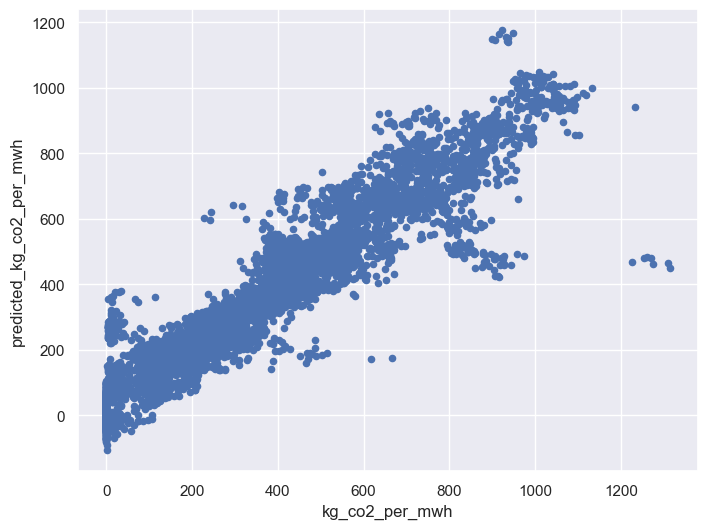

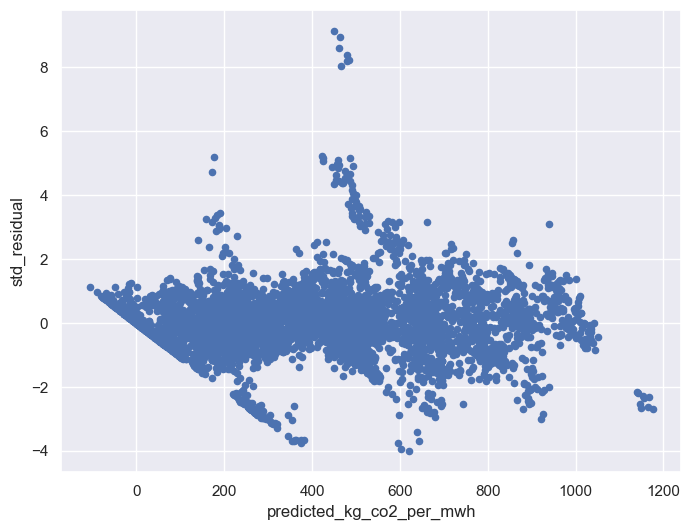

In [584]:

sns.set(rc={'figure.figsize':(8,6)})
resp_var_name = 'kg_co2_per_mwh'
lr_res = calcResiduals(gen_norm, lr_base, X_names, resp_var_name)
lr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
lr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

<Axes: xlabel='predicted_kg_co2_per_mwh', ylabel='std_residual'>

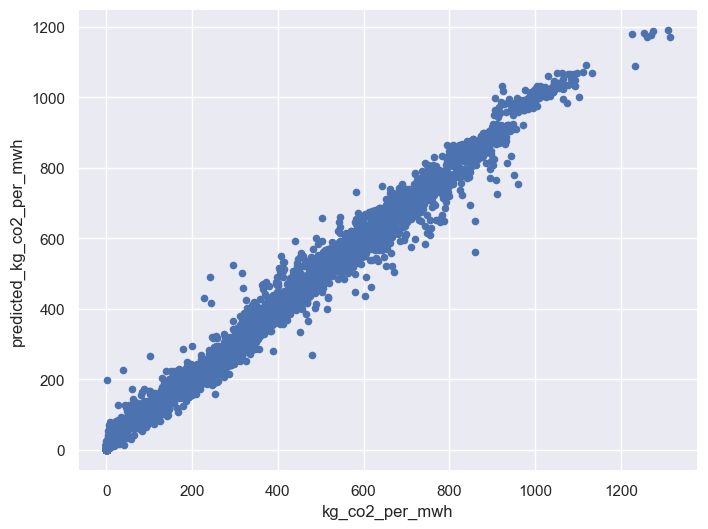

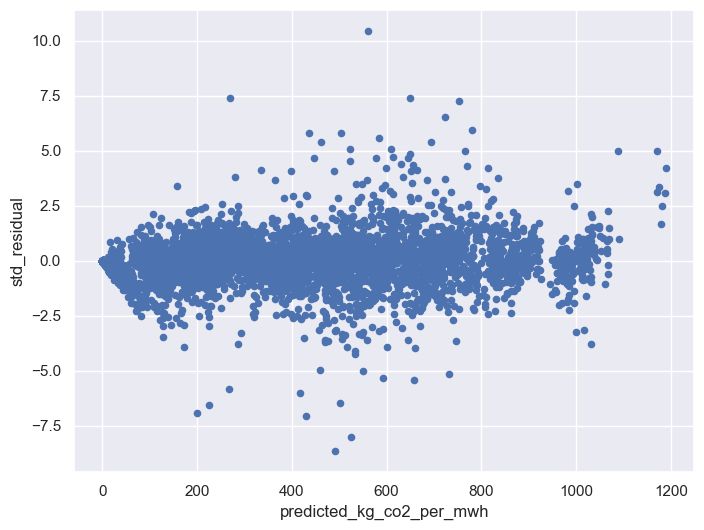

In [585]:
rfr_res = calcResiduals(gen_norm, rfr_finetuned, X_names, resp_var_name)
rfr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
rfr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

<Axes: xlabel='predicted_kg_co2_per_mwh', ylabel='std_residual'>

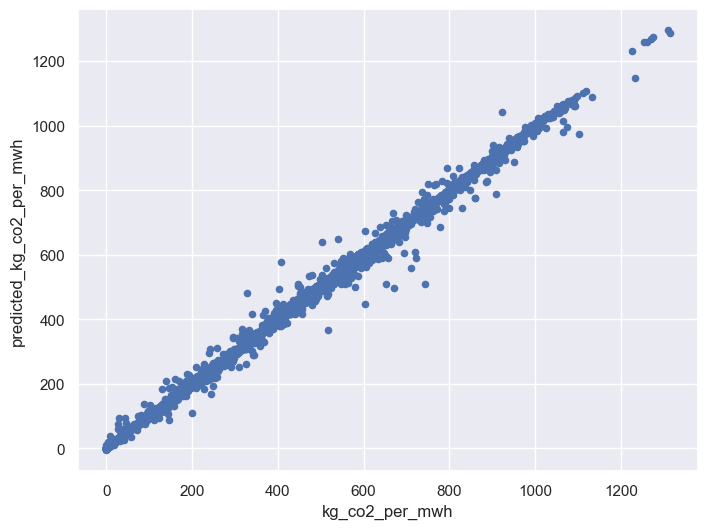

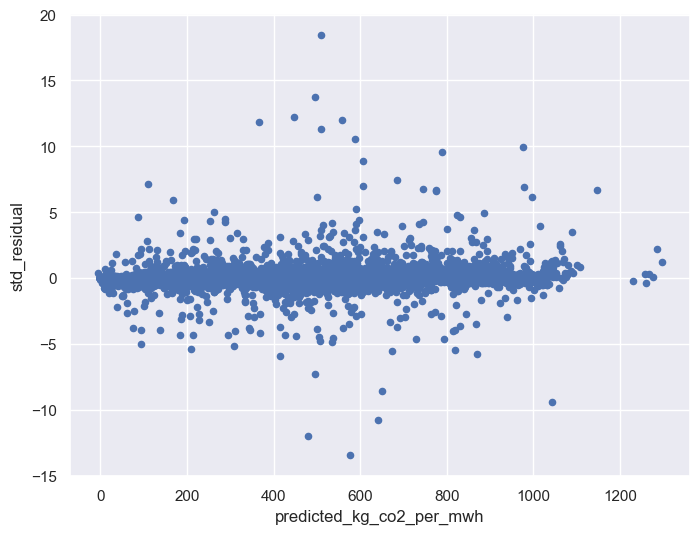

In [586]:
xgr_res = calcResiduals(gen_norm, xgr_tuned, X_names, resp_var_name)
xgr_res.plot.scatter(x=resp_var_name, y=f"predicted_{resp_var_name}")
xgr_res.plot.scatter(x=f"predicted_{resp_var_name}", y='std_residual')

In [587]:
print(xgr_res[xgr_res.std_residual < -20].T)
with open('view_output.txt', 'w') as outfile:
    xgr_res[xgr_res.std_residual < -20].T.to_csv(outfile)

Empty DataFrame
Columns: []
Index: [ba_code, index, period, av_lat, av_lon, BIT, DFO, GEO, JF, KER, LIG, MSW, NG, NUC, OTH, PC, PG, RC, RFO, SGC, SGP, SUB, SUN, TDF, WAT, WC, WND, WO, gen_mwh, co2_kton, kg_co2_per_mwh, total_cap_mw, NG_price, avg_mw_per_cap, sin_year, cos_year, sin_6mo, cos_6mo, log_BIT, log_DFO, log_GEO, log_JF, log_KER, log_LIG, log_MSW, log_NG, log_NUC, log_OTH, log_PC, log_PG, log_RC, log_RFO, log_SGC, log_SGP, log_SUB, log_SUN, log_TDF, log_WAT, log_WC, log_WND, log_WO, log_NG_price, log_avg_mw_per_cap, predicted_kg_co2_per_mwh, residual, std_residual]

[66 rows x 0 columns]


<Axes: xlabel='period'>

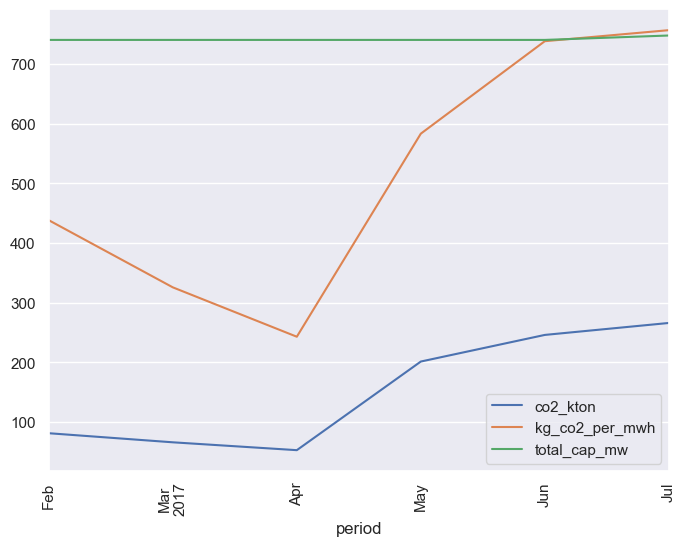

In [588]:
gen_norm[(gen_norm.ba_code == 'GVL') & (gen_norm.period > '2017-01-01') & (gen_norm.period < '2017-08-01')] \
    [['period','co2_kton','kg_co2_per_mwh','total_cap_mw']].plot(x='period',rot=90)

<Axes: xlabel='std_residual', ylabel='Count'>

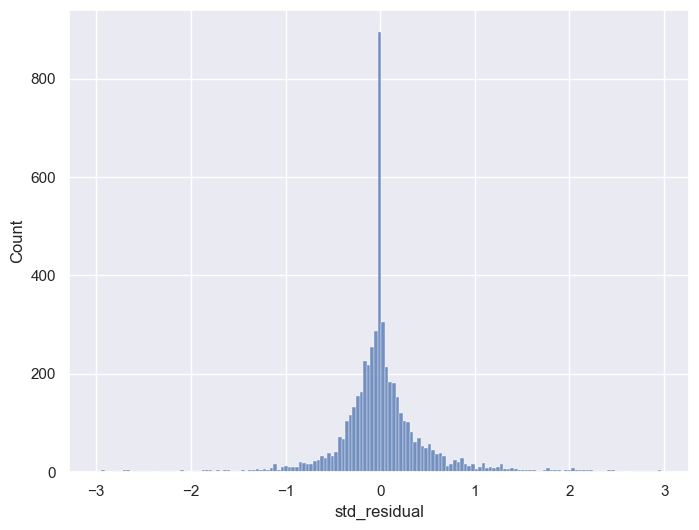

In [589]:
#xgr_res['std_residual'].hist(bins=500)
sns.histplot(data=xgr_res[(xgr_res.std_residual > -3) & (xgr_res.std_residual < 3)], x='std_residual')
#plt.ylim(0,100)
#plt.show()

In [590]:
from scipy.stats import skew, skewtest
skew(xgr_res['std_residual'])

2.556185894225644

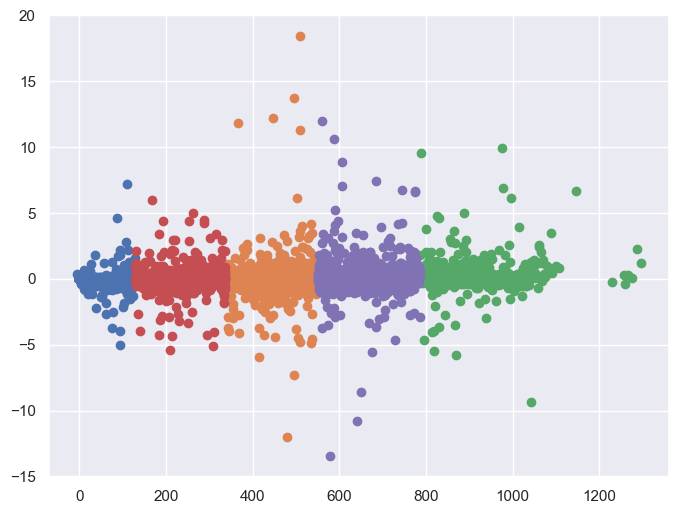

In [591]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 5, random_state=rand_st, n_init='auto')
label = kmeans.fit_predict(xgr_res[['predicted_kg_co2_per_mwh','std_residual']])
xgr_res['label'] = label

#.select_dtypes(include=np.number)
labels = np.unique(label)
for i in labels:
    plt.scatter(xgr_res[xgr_res.label == i]['predicted_kg_co2_per_mwh'], xgr_res[xgr_res.label == i]['std_residual'])
plt.show()


[['AEC', 1.7810180082719345], ['AECI', 1.8896253832277752], ['AVA', 1.6831624724836964], ['AVRN', 2.246349685552021], ['AZPS', 1.5207895730437522], ['BANC', 1.7289156208333831], ['BPAT', 1.8419049532995335], ['CHPD', 2.006340300569865], ['CISO', 1.7625547276603848], ['CPLE', 1.9274626275627484], ['CPLW', 1.7804295638297434], ['DEAA', 2.025368593161162], ['DOPD', 2.2215104894098774], ['DUK', 1.9826683921424948], ['EEI', 0.9735661018268597], ['EPE', 1.6131974015308397], ['ERCO', 1.8753739018091222], ['FMPP', 1.9407056448083289], ['FPC', 1.8124502335607833], ['FPL', 2.039643617724065], ['GCPD', 1.601136722561503], ['GRIF', 1.8765226569970122], ['GRMA', 2.1646016564369135], ['GVL', 1.3662514597014537], ['GWA', 1.5378806350728846], ['HGMA', 2.1177228370136394], ['HST', 1.5863548800261502], ['IID', 1.8677883640684634], ['IPCO', 1.9376298006918107], ['ISNE', 2.1389097399218753], ['JEA', 1.5651440325554673], ['LDWP', 1.541928030280186], ['LGEE', 1.6240051821518846], ['MISO', 1.943782563750477]

array([[<Axes: title={'center': '1'}>]], dtype=object)

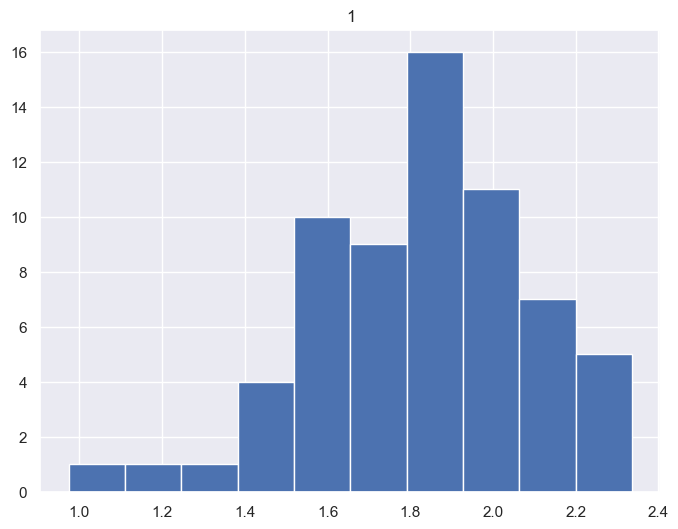

In [592]:
# check for autocorrelation between residuals
from statsmodels.stats.stattools import durbin_watson
#print(durbin_watson(xgr_res['residual'])) #probably not valid since there are multiple records per time
dw_by_ba = []
for ba in xgr_res.ba_code.unique():
    #print(ba)
    #print(f"  {durbin_watson(xgr_res[xgr_res.ba_code == ba]['residual'])}")
    dw_by_ba.append([ba, durbin_watson(xgr_res[xgr_res.ba_code == ba]['residual'])])
print(dw_by_ba)
dw_check = pd.DataFrame(dw_by_ba)
dw_check.hist()


In [593]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(rfr_finetuned.estimators_[0], feature_names=X_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data, format='png')
graph.render('tree', view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.659707 to fit


'tree.png'

In [594]:
xgr_tuned.feature_importances_

array([5.4114334e-02, 3.1691764e-02, 1.5841166e-02, 3.6343068e-03,
       6.6067814e-03, 1.3796371e-04, 5.7512191e-03, 1.3902462e-03,
       9.0299052e-04, 1.9137209e-02, 7.9599909e-02, 7.2055720e-03,
       4.0391855e-02, 6.2670966e-05, 5.6698799e-02, 7.0930325e-04,
       5.6930230e-04, 3.6829428e-03, 4.6366859e-02, 6.0936026e-03,
       2.8805400e-04, 1.2066152e-01, 3.8577465e-04, 1.8239267e-02,
       2.0706194e-04, 5.1337533e-04, 2.0388484e-03, 1.0340989e-03,
       7.8860164e-04, 5.3177931e-04, 6.6169258e-04, 7.1797833e-02,
       9.5147854e-03, 8.8831421e-04, 9.0265850e-05, 4.2448621e-04,
       8.8312902e-04, 7.4776419e-04, 2.7499987e-02, 7.6584131e-02,
       1.1759435e-02, 1.2950091e-02, 0.0000000e+00, 3.8341213e-02,
       6.0328579e-04, 4.1191833e-04, 8.5122213e-03, 6.9715306e-02,
       7.9651969e-03, 3.5929849e-04, 9.0784416e-02, 6.1465580e-05,
       3.6207754e-02, 3.9204331e-03, 9.6548750e-04, 3.0729233e-03],
      dtype=float32)

<Axes: title={'center': 'Random Forest Regression Feature Importance'}, ylabel='feature'>

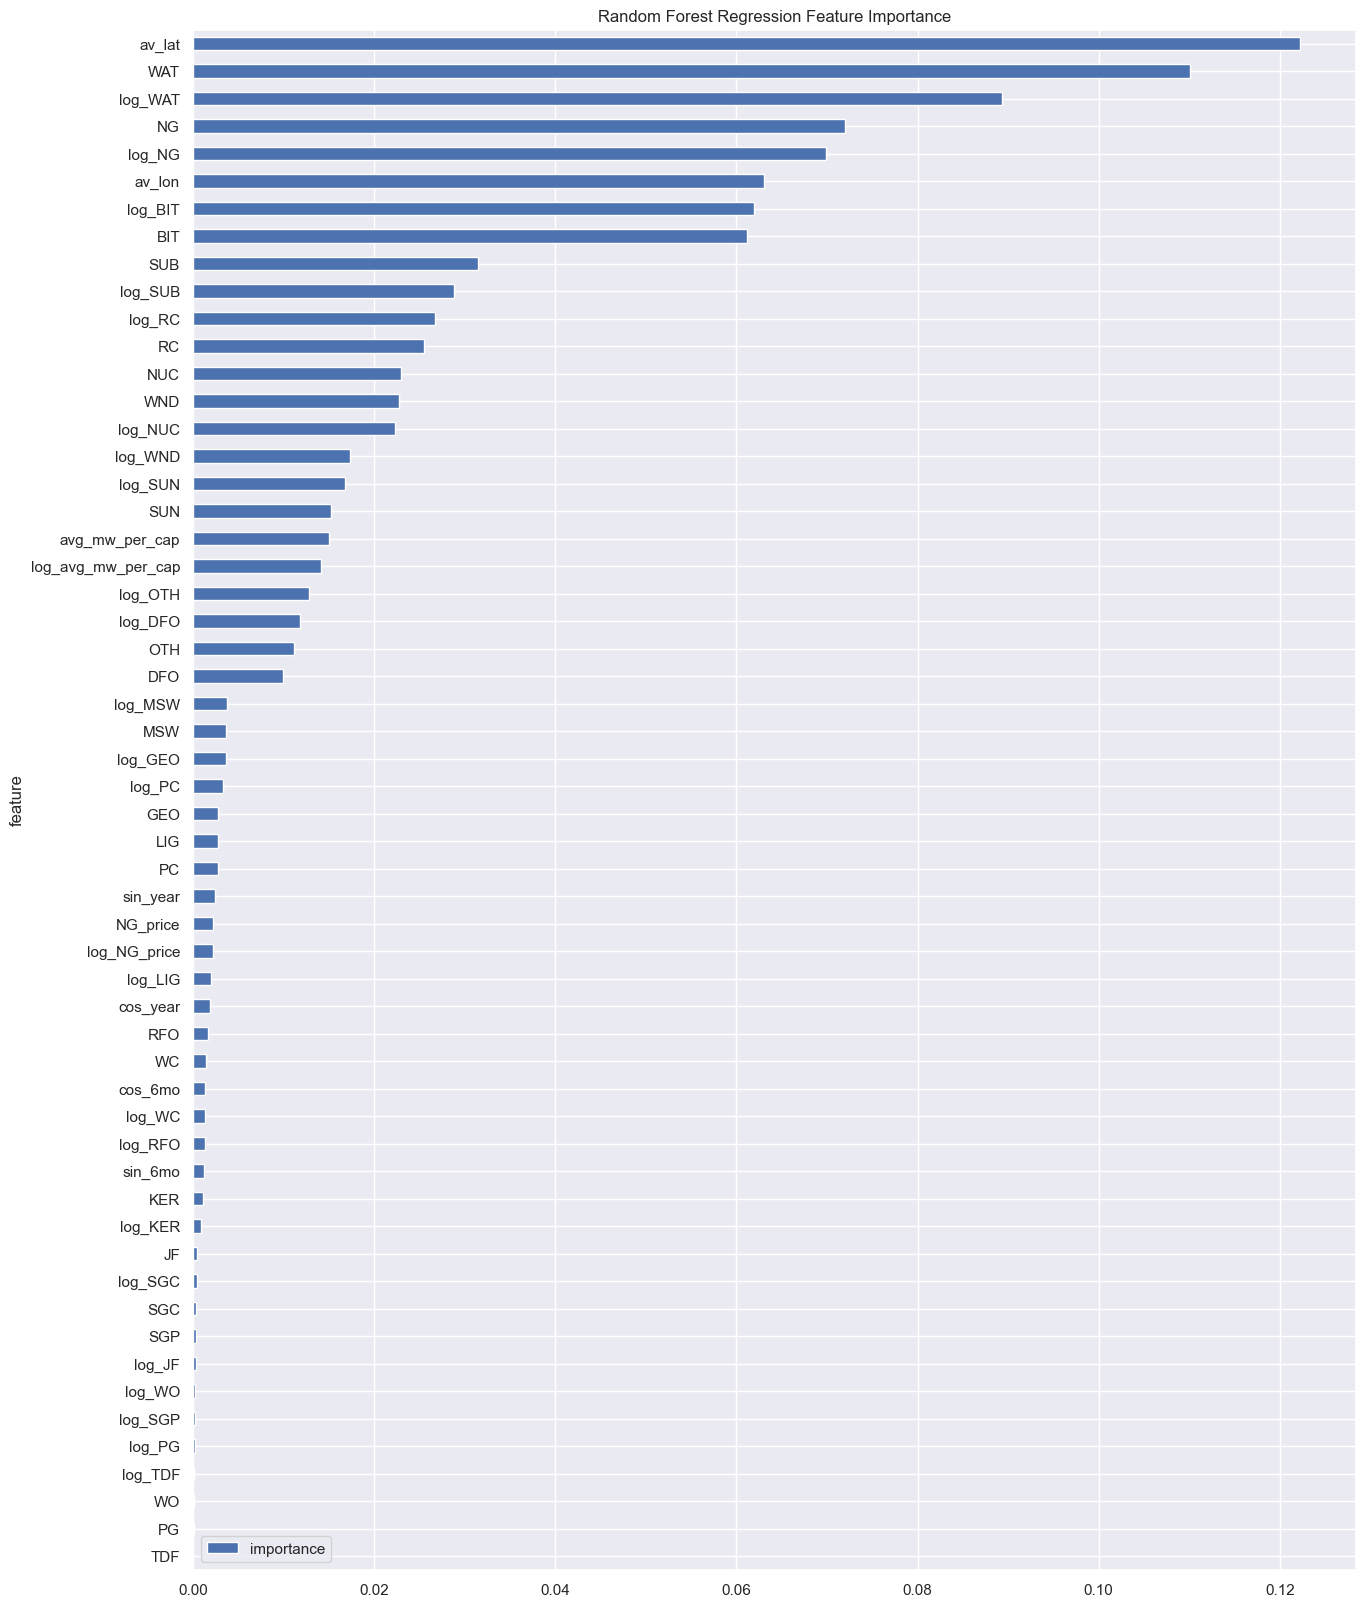

In [595]:
fx_imp = pd.DataFrame({'feature': X_names, 'importance': rfr_finetuned.feature_importances_})
fx_imp = fx_imp.sort_values(by='importance')
fx_imp.plot.barh(x='feature', y='importance', figsize=(15,20), title="Random Forest Regression Feature Importance")

<Axes: title={'center': 'XGBoost Regression Feature Importance'}, ylabel='feature'>

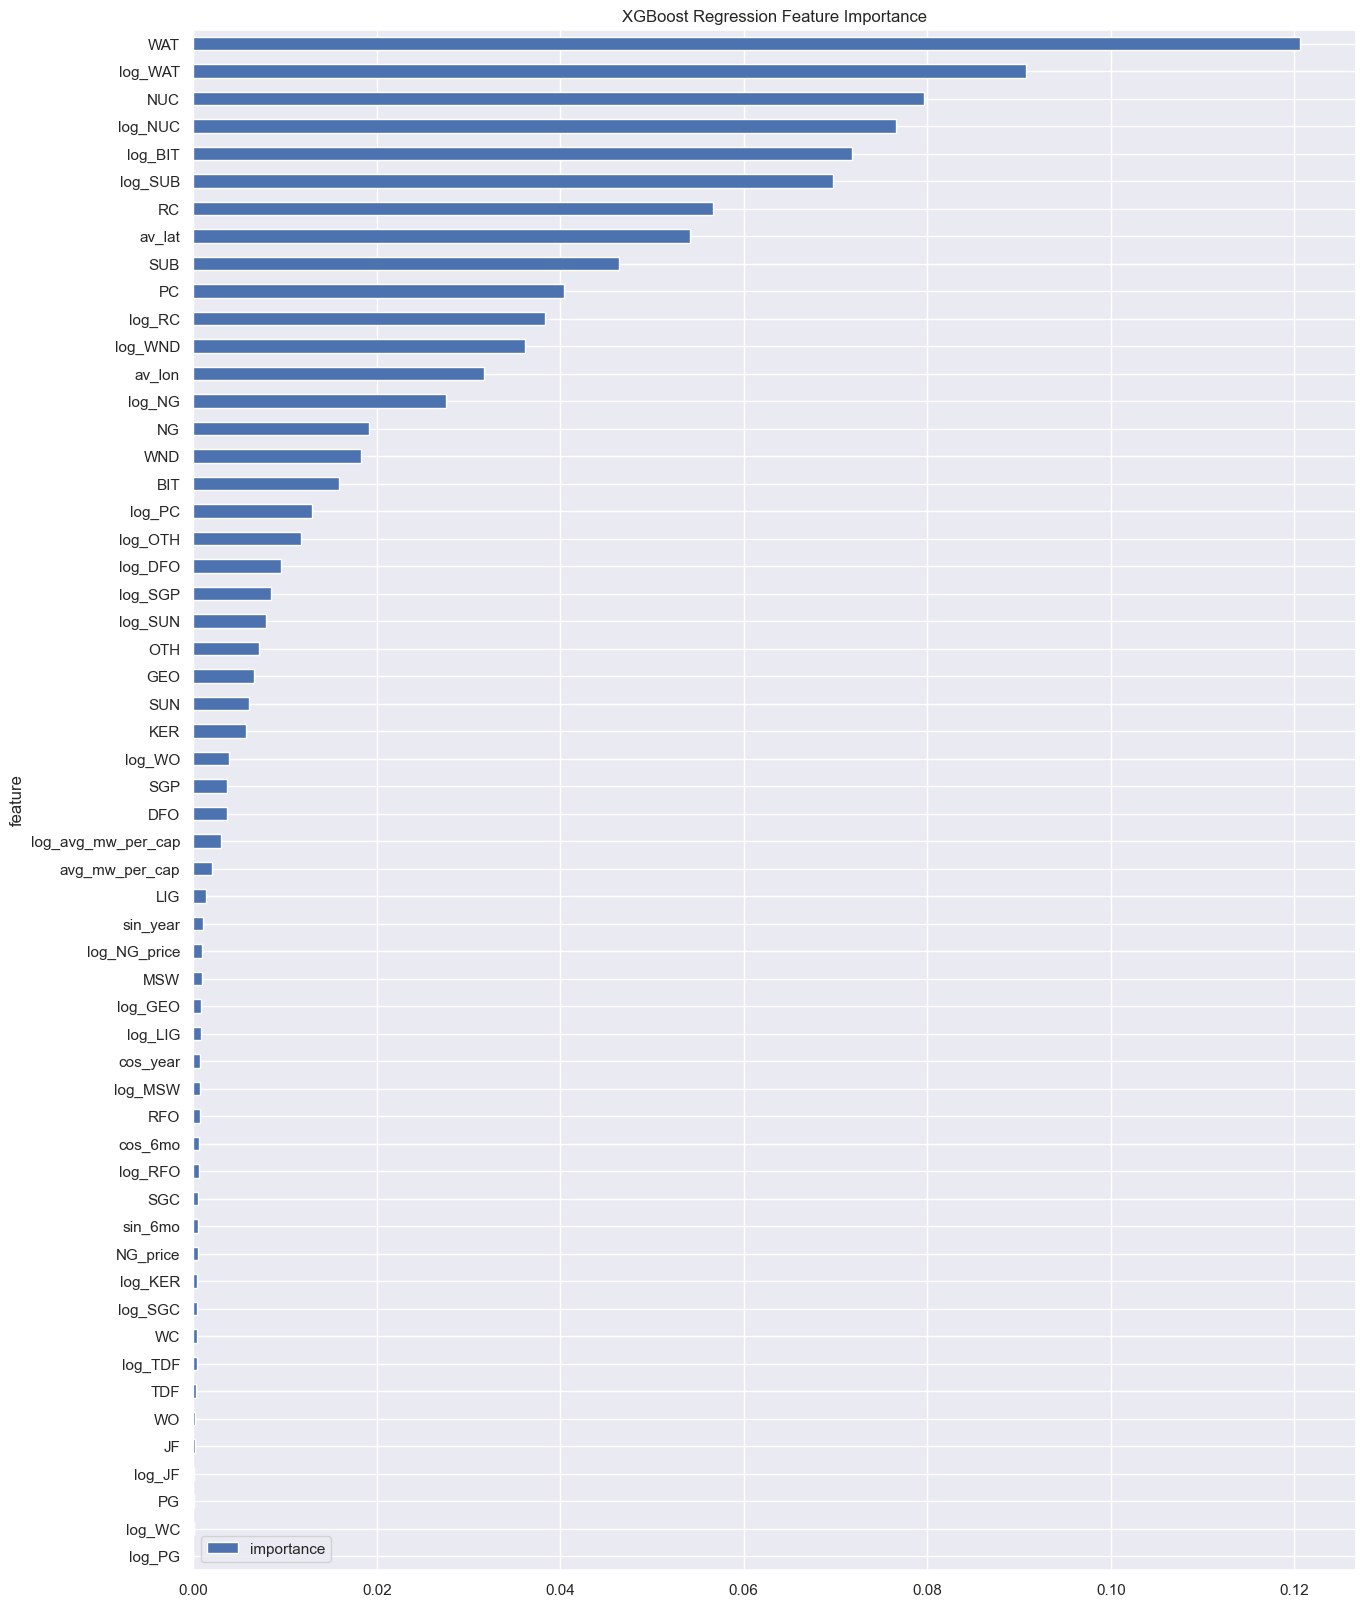

In [596]:
fx_imp = pd.DataFrame({'feature': X_names, 'importance': xgr_tuned.feature_importances_})
fx_imp = fx_imp.sort_values(by='importance')
fx_imp.plot.barh(x='feature', y='importance', figsize=(15,20), title='XGBoost Regression Feature Importance')

## Use model to predict how adding 100 MW of solar generation capacity to a Balancing Authority would affect CO2 emissions

In [597]:
# average most recent two years of reliable configuration data to approximate current configuration (2020 and 2021)
# same for gen_mwh to approximate future generation (~demand)? Or use more years for smoothing?

add_solar_mw = 100
add_wind_mw = 0

In [598]:
def getGenData(explan_path, resp_path, data_cutoff):
    genconf = pd.read_csv(explan_path, low_memory=False)
    genout = pd.read_csv(resp_path, low_memory=False)
    # EIA data is not finalized until fall of the year following the reporting period, so cut off data at end of 2021
    genconf = genconf[genconf.period < data_cutoff]
    #genout = genout[genout.period < data_cutoff]
    return genconf, genout

In [599]:
def addNotionalCapacity(genconf, add_solar_mw, add_wind_mw):
    genconf['SUN'] += add_solar_mw
    genconf['WND'] += add_wind_mw
    return genconf

In [600]:
def prepFeaturesAndTarget(genconf, genout):
    # calculate total generation capacity per row
    genconf['total_cap_mw'] = genconf.drop(['av_lat','av_lon'], axis=1).sum(axis=1, numeric_only=True)
    # divide capacity per energy source by total capacity
    genconf_norm = genconf[['ba_code','period','av_lat','av_lon','total_cap_mw']].join(genconf.drop(['av_lat','av_lon'], axis=1).select_dtypes \
                                                                   (include=np.number).apply(lambda x : x/genconf['total_cap_mw']) \
                                                                    .drop(columns=['total_cap_mw']))
    #normalize latitude to range 0,1
    genconf_norm['av_lat'] = genconf_norm['av_lat'].apply(lambda x: (x-genconf_norm['av_lat'].min())/(genconf_norm['av_lat'].max() \
                                                                           - genconf_norm['av_lat'].min()))
    #normalize longitude to range 0,1
    genconf_norm['av_lon'] = genconf_norm['av_lon'].apply(lambda x: (x-genconf_norm['av_lon'].min())/(genconf_norm['av_lon'].max() \
                                                                           - genconf_norm['av_lon'].min()))
    
    genout = genout[['ba_code', 'period', 'gen_mwh', 'co2_kton', 'kg_co2_per_mwh']]
    genout_norm = genout.set_index(['ba_code','period']).join(genconf[['ba_code','period','total_cap_mw']].set_index(['ba_code','period']))
    genout_norm.dropna()
    # normalize using capacity * time, i.e. how much could a BA generate in a month if 
    # running all generators at 100% capacity
    # using 31 days per month in an effort to keep result <= 1.
    genout_norm['avg_mw_per_cap'] = genout_norm['gen_mwh']/(genout_norm['total_cap_mw']*31*24)
    genout_norm = genout_norm.reset_index()
    # remove rows with nonsense generation values (generation exceeds reported capacity)
    genout_norm = genout_norm[genout_norm.avg_mw_per_cap <= 1]
    gen_norm = genconf_norm.drop(columns='total_cap_mw').set_index(['ba_code', 'period']).join(genout_norm \
                                                                  .set_index(['ba_code', 'period']))
    gen_norm = gen_norm.reset_index()
    
    ng_price_path = 'NG_price.csv'
    ng_price = pd.read_csv(ng_price_path, low_memory=False)
    ng_price.head()
    gen_norm = gen_norm.set_index(['period']).join(ng_price.set_index('period')).reset_index()
    print(gen_norm.shape)
    gen_norm = gen_norm.dropna()
    print(gen_norm.shape)
    gen_norm = gen_norm.reset_index()
    move_col = gen_norm.pop('ba_code')
    gen_norm.insert(0, move_col.name, move_col)
    move_col = gen_norm.pop('NG_price')
    gen_norm.insert(gen_norm.columns.get_loc('avg_mw_per_cap'), move_col.name, move_col)
    # normalize natural gas price
    gen_norm['NG_price'] = (gen_norm['NG_price'] - gen_norm['NG_price'].min())/(gen_norm['NG_price'].max() \
        - gen_norm['NG_price'].min())
    gen_norm = gen_norm.sort_values(by=['ba_code','period'])
    gen_norm = gen_norm[gen_norm.kg_co2_per_mwh >= 0]
    
    gen_norm['period'] = pd.to_datetime(gen_norm['period'])
    # create Julian date column (days since noon on 1 Jan 4713 BC)
    gen_norm['julian'] = gen_norm['period'].apply(lambda x : pd.Timestamp(x).to_julian_date())
    # create sine and cosine of time features
    gen_norm['sin_year'] = np.sin(gen_norm['julian'] / 365.25 * 2 * np.pi)
    gen_norm['cos_year'] = np.cos(gen_norm['julian'] / 365.25 * 2 * np.pi)
    gen_norm['sin_6mo'] = np.sin(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
    gen_norm['cos_6mo'] = np.cos(gen_norm['julian'] / (365.25/2) * 2 * np.pi)
    gen_norm = gen_norm.drop(columns=['julian'])
    not_features = ['ba_code', 'index', 'period', 'kg_co2_per_mwh', 'gen_mwh', 'co2_kton', 'total_cap_mw',]
    X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
    # list feature names to log transform
    no_log = ['av_lat', 'av_lon', 'sin_year', 'cos_year', 'sin_6mo', 'cos_6mo']
    X_to_log = [i for i in X_names if i not in no_log]
    X_log_names = [f"log_{i}" for i in X_to_log]
    gen_norm[X_log_names] = gen_norm[X_to_log].apply(lambda x: np.log(1+x))
    #X_names = [i for i in list(gen_norm.columns.values) if i not in not_features]
    return gen_norm


In [601]:
genconfig, genoutput = getGenData(explan_path, resp_path, data_cutoff)
genconf_hyp = addNotionalCapacity(genconfig, add_solar_mw, add_wind_mw)
gen_hyp = prepFeaturesAndTarget(genconf_hyp, genoutput)
gen_hyp.head()

(6996, 33)
(5712, 33)


,ba_code,index,period,av_lat,av_lon,BIT,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,0,2013-01-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.460054
51,AEC,63,2013-02-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.445811
107,AEC,126,2013-03-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.404702,0.468948
161,AEC,189,2013-04-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.458207,0.370073
217,AEC,252,2013-05-01,0.247954,0.704774,0.27158,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.439214,0.332300


In [602]:
gen_hyp.shape

(5712, 63)

In [603]:
#set feature variables to reflect current conditions, i.e. configuration of BAs
curr_start = '2021-01-01'
curr_end = '2022-01-01'

gen_hyp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5712 entries, 0 to 5711
Data columns (total 63 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ba_code             5712 non-null   object        
 1   index               5712 non-null   int64         
 2   period              5712 non-null   datetime64[ns]
 3   av_lat              5712 non-null   float64       
 4   av_lon              5712 non-null   float64       
 5   BIT                 5712 non-null   float64       
 6   DFO                 5712 non-null   float64       
 7   GEO                 5712 non-null   float64       
 8   JF                  5712 non-null   float64       
 9   KER                 5712 non-null   float64       
 10  LIG                 5712 non-null   float64       
 11  MSW                 5712 non-null   float64       
 12  NG                  5712 non-null   float64       
 13  NUC                 5712 non-null   float64       
 1

In [604]:
gen_hyp.shape

(5712, 63)

In [605]:
gen_norm.shape

(5523, 63)

In [606]:
gen_hyp = gen_norm.set_index(['ba_code', 'period'])[['BIT']].join(gen_hyp.set_index(['ba_code', 'period']), rsuffix='drop') \
    .drop(columns=['BITdrop']).reset_index()

In [607]:
gen_hyp.shape

(5523, 63)

In [608]:
gen_hyp.head()

,ba_code,period,BIT,index,av_lat,av_lon,DFO,GEO,JF,KER,...,log_SGP,log_SUB,log_SUN,log_TDF,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap
0,AEC,2013-01-01,0.286018,0,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.460054
1,AEC,2013-02-01,0.286018,63,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.328596,0.445811
2,AEC,2013-03-01,0.286018,126,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.404702,0.468948
3,AEC,2013-04-01,0.286018,189,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.458207,0.370073
4,AEC,2013-05-01,0.286018,252,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049247,0.0,0.004131,0.0,0.0,0.0,0.439214,0.332300


In [609]:
gen_hyp['kg_co2_per_mwh_hyp_pred'] = xgr_tuned.predict(gen_hyp[X_names])
gen_hyp['kg_co2_per_mwh_curr_pred'] = xgr_tuned.predict(gen_norm[X_names])
gen_hyp['co2_kton_curr_pred'] = gen_hyp['gen_mwh'] * gen_hyp['kg_co2_per_mwh_curr_pred'] / 1e6
gen_hyp['co2_kton_hyp_pred'] = gen_hyp['gen_mwh'] * gen_hyp['kg_co2_per_mwh_hyp_pred'] / 1e6
#gen_hyp = gen_hyp[(gen_hyp.period > curr_start) & (gen_hyp.period <= curr_end)]

In [610]:
gen_hyp['month'] = gen_hyp['period'].apply(lambda m : pd.to_datetime(m).month)
gen_hyp = gen_hyp.drop(columns='period').groupby(['ba_code', 'month']).mean().reset_index()
gen_hyp.head()

,ba_code,month,BIT,index,av_lat,av_lon,DFO,GEO,JF,KER,...,log_WAT,log_WC,log_WND,log_WO,log_NG_price,log_avg_mw_per_cap,kg_co2_per_mwh_hyp_pred,kg_co2_per_mwh_curr_pred,co2_kton_curr_pred,co2_kton_hyp_pred
0,AEC,1,0.254238,3097.333333,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.289683,0.519044,483.455292,525.320251,520.266682,477.421643
1,AEC,2,0.254238,3162.111111,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.300616,0.455967,458.937714,501.294708,416.571277,379.810190
2,AEC,3,0.254238,3226.888889,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.244605,0.451574,472.716858,508.477661,415.413622,385.618631
3,AEC,4,0.254238,3291.666667,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.247221,0.387864,508.812347,553.939148,374.795965,343.848768
4,AEC,5,0.254238,3356.444444,0.247954,0.704774,0.0,0.0,0.0,0.0,...,0.004301,0.0,0.0,0.0,0.254796,0.474733,504.331879,569.831543,482.128282,429.959242


<Axes: xlabel='month'>

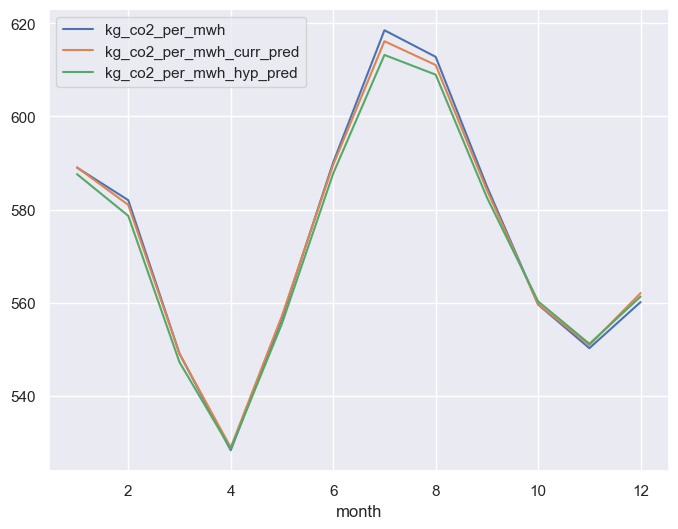

In [611]:
gen_hyp[gen_hyp.ba_code == 'MISO'].set_index('month')[['kg_co2_per_mwh', \
                        'kg_co2_per_mwh_curr_pred', 'kg_co2_per_mwh_hyp_pred']].plot()

<Axes: xlabel='month'>

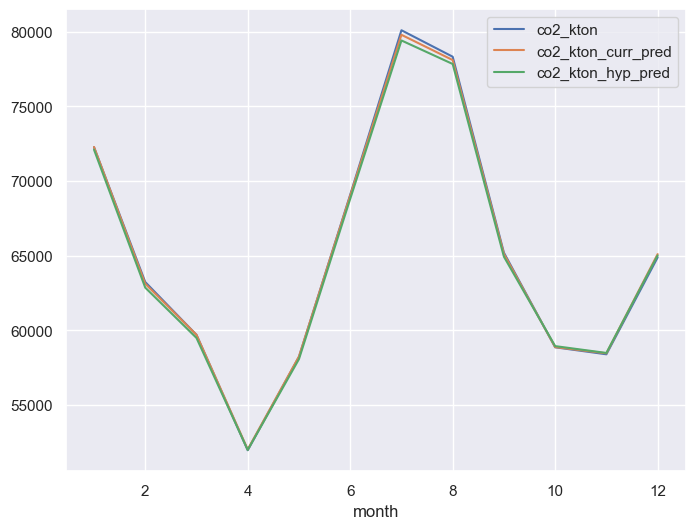

In [612]:
gen_hyp[gen_hyp.ba_code == 'MISO'].set_index('month')[['co2_kton','co2_kton_curr_pred' \
                                                       , 'co2_kton_hyp_pred']].plot()

<Axes: xlabel='month'>

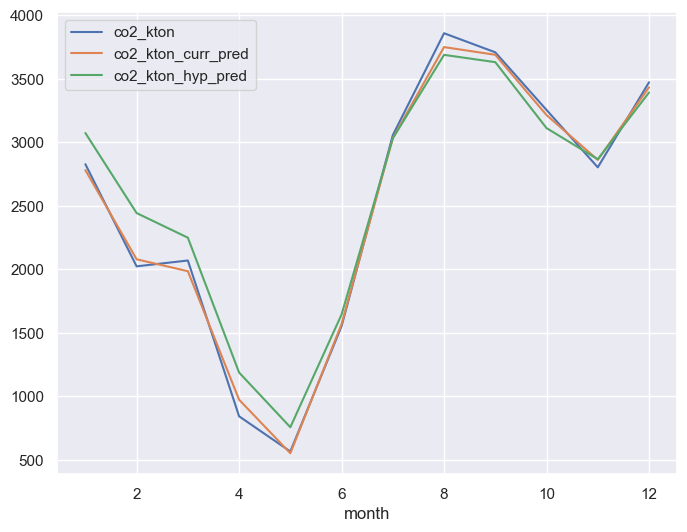

In [613]:
gen_hyp[gen_hyp.ba_code == 'BPAT'].set_index('month')[['co2_kton','co2_kton_curr_pred' \
                                                       , 'co2_kton_hyp_pred']].plot()

<Axes: xlabel='month'>

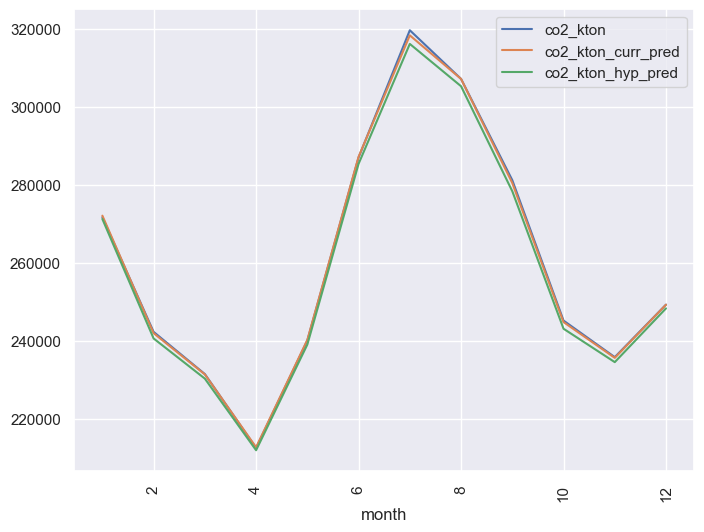

In [614]:
gen_hyp.groupby('month').sum()[['co2_kton','co2_kton_curr_pred', 'co2_kton_hyp_pred']].plot(rot=90)

In [615]:
co2_annual = gen_hyp.groupby('ba_code')[['co2_kton','co2_kton_curr_pred', 'co2_kton_hyp_pred']].sum()
co2_annual['delta_co2_kton_pred'] = co2_annual['co2_kton_hyp_pred'] - co2_annual['co2_kton_curr_pred']
co2_annual.head()

,co2_kton,co2_kton_curr_pred,co2_kton_hyp_pred,delta_co2_kton_pred
ba_code,,,,
AEC,5937.617863,5981.933010,5457.563221,-524.369789
AECI,32743.805163,32724.873485,31919.105909,-805.767576
AVA,1374.714470,1384.959167,1571.384504,186.425336
AVRN,0.000000,0.146531,8.201748,8.055218
AZPS,28582.572574,28578.623080,27429.728571,-1148.894509


<Axes: ylabel='ba_code'>

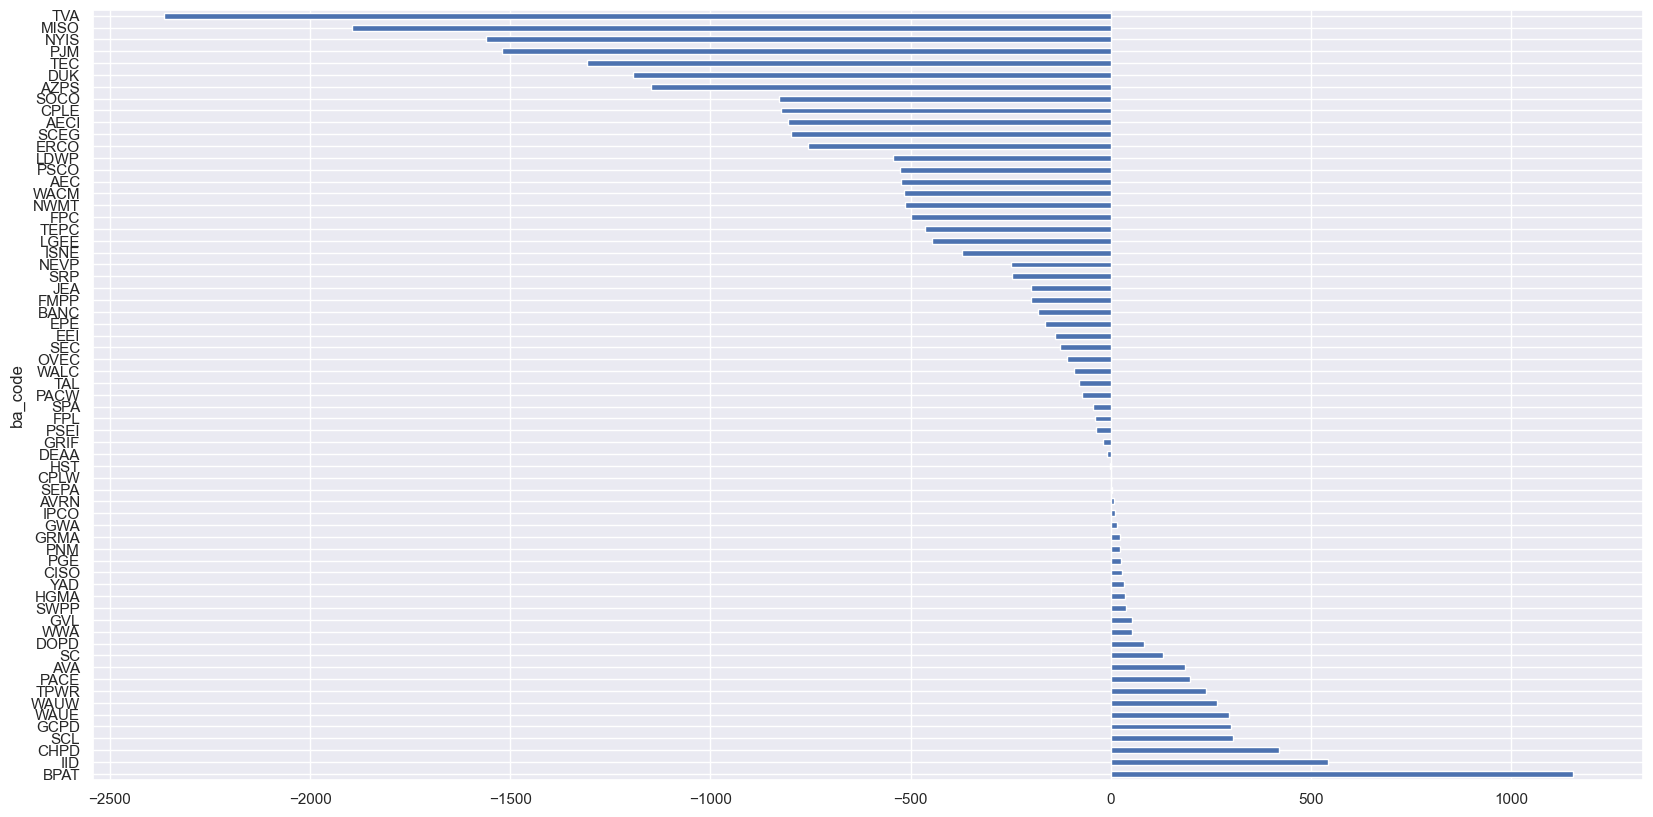

In [616]:
co2_annual['delta_co2_kton_pred'].sort_values(ascending=False).plot(kind='barh', figsize = (20,10))


In [617]:
# everything below is garbage

In [618]:
# set response variables to reflect average over t years as a baseline for comparison
av_start = '20'


gen_curr_em = gen_snap[(gen_snap.period > curr_start) & (gen_snap.period <= curr_end)] \
    [[i for i in list(gen_snap.columns.values) if i not in X_names]]
gen_curr_em.head()

NameError: name 'gen_snap' is not defined

In [ ]:
av_gen_start = '2020-01-01'
av_gen_end = '2022-01-01'
av_generation = gen_snap[(gen_snap.period > av_gen_start) & (gen_snap.period <= av_gen_end)] \
    [['ba_code', 'period', 'gen_mwh']]
av_generation.head()

,ba_code,period,gen_mwh
3643,AEC,2020-02-01,791680.11
3687,AEC,2020-03-01,812973.60
3732,AEC,2020-04-01,573313.82
3779,AEC,2020-05-01,828590.68
3824,AEC,2020-06-01,1069249.80


In [ ]:
gen_current['month'] = gen_current['period'].apply(lambda m : pd.to_datetime(m).month)
gen_current = gen_current.drop(columns='period').groupby(['ba_code', 'month']).mean()
gen_current.head()

KeyError: 'period'

In [ ]:
gen_curr_em['month'] = gen_curr_em['period'].apply(lambda m : pd.to_datetime(m).month)
gen_curr_em = gen_curr_em.drop(columns=['period','gen_mwh']).groupby(['ba_code', 'month']).mean()
gen_curr_em.head()

co2_kton  kg_co2_per_mwh  total_cap_mw
ba_code month                                          
AEC     1      304.857035      403.982248        1343.0
        2      323.319125      407.039237        1612.0
        3      317.677379      415.748788        1612.0
        4      260.681085      489.508416        1612.0
        5      332.744602      404.832553        1612.0

In [ ]:
av_generation['month'] = av_generation['period'].apply(lambda m : pd.to_datetime(m).month)
av_generation = av_generation.drop(columns='period').groupby(['ba_code', 'month']).mean()
av_generation.head()

gen_mwh
ba_code month            
AEC     1      754629.780
        2      794279.415
        3      760752.470
        4      524776.510
        5      821927.185

In [ ]:
gen_hyp = gen_current.join(gen_curr_em).join(av_generation)

In [ ]:
for c in list(gen_hyp.columns.values):
    if gen_hyp[c].isna().sum() > 0:
        print(f"{c} has {gen_hyp[c].isna().sum()} NaN")

In [ ]:
gen_hyp.shape

(533, 60)

In [ ]:
gen_hyp['kg_co2_per_mwh_curr_pred'] = rfr_finetuned.predict(gen_hyp[X_names])
gen_hyp.head()

av_lat    av_lon       BIT  DFO  GEO   JF  KER  LIG  MSW   
ba_code month                                                               
AEC     1      0.247954  0.704774  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  \
        2      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        3      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        4      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        5      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   

                     NG  ...  log_WC  log_WND  log_WO  log_NG_price   
ba_code month            ...                                          
AEC     1      0.990320  ...     0.0      0.0     0.0      0.220853  \
        2      0.848695  ...     0.0      0.0     0.0      0.338985   
        3      0.848695  ...     0.0      0.0     0.0      0.120080   
        4      0.848695  ...     0.0      0.0     0.0      0.118248   
        5      0.848695  ...     0.0      0.0     0.0      0.141991   

               log_avg_mw_per_cap    co2_kton  kg_co2_per_mwh  total_cap_mw   
ba_code month                                                                 
AEC     1                0.562606  304.857035      403.982248        1343.0  \
        2                0.517372  323.319125      407.039237        1612.0   
        3                0.496988  317.677379      415.748788        1612.0   
        4                0.366556  260.681085      489.508416        1612.0   
        5                0.530817  332.744602      404.832553        1612.0   

                  gen_mwh  kg_co2_per_mwh_curr_pred  
ba_code month                                        
AEC     1      754629.780                412.017001  
        2      794279.415                463.938439  
        3      760752.470                456.155083  
        4      524776.510                493.368329  
        5      821927.185                461.115327  

[5 rows x 61 columns]

In [ ]:
gen_hyp = gen_hyp.rename(columns={'SUN':'SUN_old'})
gen_hyp['SUN'] = (gen_hyp['SUN_old'] * gen_hyp['total_cap_mw'] + add_solar_mw) / (gen_hyp['total_cap_mw'] + add_solar_mw)


gen_hyp['kg_co2_per_mwh_hyp_pred'] = rfr_tuned.predict(gen_hyp[X_names])
gen_hyp.head()

av_lat    av_lon       BIT  DFO  GEO   JF  KER  LIG  MSW   
ba_code month                                                               
AEC     1      0.247954  0.704774  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  \
        2      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        3      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        4      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   
        5      0.247954  0.704774  0.143009  0.0  0.0  0.0  0.0  0.0  0.0   

                     NG  ...  log_WO  log_NG_price  log_avg_mw_per_cap   
ba_code month            ...                                             
AEC     1      0.990320  ...     0.0      0.220853            0.562606  \
        2      0.848695  ...     0.0      0.338985            0.517372   
        3      0.848695  ...     0.0      0.120080            0.496988   
        4      0.848695  ...     0.0      0.118248            0.366556   
        5      0.848695  ...     0.0      0.141991            0.530817   

                 co2_kton  kg_co2_per_mwh  total_cap_mw     gen_mwh   
ba_code month                                                         
AEC     1      304.857035      403.982248        1343.0  754629.780  \
        2      323.319125      407.039237        1612.0  794279.415   
        3      317.677379      415.748788        1612.0  760752.470   
        4      260.681085      489.508416        1612.0  524776.510   
        5      332.744602      404.832553        1612.0  821927.185   

               kg_co2_per_mwh_curr_pred       SUN  kg_co2_per_mwh_hyp_pred  
ba_code month                                                               
AEC     1                    412.017001  0.069300               423.997629  
        2                    463.938439  0.058411               470.602707  
        3                    456.155083  0.058411               460.932791  
        4                    493.368329  0.058411               477.661670  
        5                    461.115327  0.058411               464.721054  

[5 rows x 63 columns]